<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/w3d2_fixes/tutorials/W3D2_BasicReinforcementLearning/W3D2_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 1: Introduction to Reinforcement Learning

**Week 3, Day 2: Basic Reinforcement Learning (RL)**

**By Neuromatch Academy**

__Content creators:__  Matthew Sargent, Anoop Kulkarni, Sowmya Parthiban, Feryal Behbahani, Jane Wang

__Content reviewers:__ Ezekiel Williams, Mehul Rastogi, Lily Cheng, Roberto Guidotti, Arush Tagade, Kelson Shilling-Scrivo

__Content editors:__ Spiros Chavlis 

__Production editors:__ Spiros Chavlis

__Post-Production team:__ Gagana B, Spiros Chavlis

**Our 2021 Sponsors, including Presenting Sponsor Facebook Reality Labs**

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Tutorial Objectives

By the end of the tutorial, you should be able to:

1. Within the RL framework, be able to identify the different components: Environment, Agent, States, and Actions. 
2. Understand the Bellman equation and components involved. 
3. Implement tabular value-based model-free learning (Q-learning and SARSA).
4. Discuss real-world applications and ethical issues of RL.

By completing the Bonus sections, you should be able to:
1. Run a DQN agent and experiment with different hyperparameters.
2. Have a high-level understanding of other (nonvalue-based) RL methods.

In [1]:
# @title Tutorial slides

from IPython.display import IFrame
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/m3kqy/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

These are the slides for all videos in this tutorial. If you want to locally download the slides, click [here](https://osf.io/m3kqy/download).

---
# Setup

Run the following *Setup* cells in order to set up needed functions. Don't worry about the code for now!

**Note:** There is an issue with some images not showing up if you're using a Safari browser. Please switch to Chrome if this is the case.

In [2]:
# @title Install requirements
from IPython.display import clear_output
# @markdown We install the acme library, see [here](https://github.com/deepmind/acme) for more info.

# @markdown **WARNING:** There may be *errors* and/or *warnings* reported during the installation. However, they should be ignored.
!pip install --upgrade pip --quiet
!pip install imageio --quiet
!pip install imageio-ffmpeg
!pip install gym --quiet
!pip install enum34 --quiet
!pip install dm-env --quiet
!pip install pandas --quiet
!pip install grpcio==1.34.0 --quiet
!pip install tensorflow --quiet
!pip install typing --quiet
!pip install einops --quiet
!pip install dm-acme --quiet
!pip install dm-acme[reverb] --quiet
!pip install dm-acme[jax,tensorflow] --quiet
!pip install dm-acme[envs] --quiet
!pip install dm-env --quiet

!pip install git+https://github.com/NeuromatchAcademy/evaltools --quiet
from evaltools.airtable import AirtableForm

# Generate airtable form
atform = AirtableForm('appn7VdPRseSoMXEG','W3D2_T1','https://portal.neuromatchacademy.org/api/redirect/to/3e77471d-4de0-4e43-a026-9cfb603b5197')
clear_output()

In [3]:
# Import modules
import gym
import enum
import copy
import time
import acme
import torch
import base64
import dm_env
import IPython
import imageio
import warnings
import itertools
import collections

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib as mpl
import matplotlib.pyplot as plt

from acme import specs
from acme import wrappers
from acme.utils import tree_utils
from acme.utils import loggers
from torch.autograd import Variable
from torch.distributions import Categorical
from typing import Callable, Sequence

warnings.filterwarnings('ignore')
np.set_printoptions(precision=3, suppress=1)

In [4]:
# @title Figure settings
import ipywidgets as widgets       # Interactive display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")
mpl.rc('image', cmap='Blues')

In [5]:
# @title Helper Functions
# @markdown Implement helpers for value visualisation

map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]


def plot_values(values, colormap='pink', vmin=-1, vmax=10):
  """
  Plots incoming values

  Args: 
    values: List
      List of values to be plotted
    colormap: String
      Defines colormap of plot
    vmin: Integer
      Smallest possible value within "values"
    vmax: Integer 
      Highest possible value within "values"

  Returns: 
    Nothing
  """
  plt.imshow(values, interpolation="nearest",
             cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])


def plot_state_value(state_values, epsilon=0.1):
  """
  Helper function to plot state value 

  Args: 
    state_values: np.ndarray
      Action values with shape (9, 10, 4)
    epsilon: Float 
      Sets the exploitation-exploration control hyperparameter [default=0.1]

  Returns: 
    Nothing
  """
  q = state_values
  fig = plt.figure(figsize=(4, 4))
  vmin = np.min(state_values)
  vmax = np.max(state_values)
  v = (1 - epsilon) * np.max(q, axis=-1) + epsilon * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")


def plot_action_values(action_values, epsilon=0.1):
  """
  Helper function to plot action value 

  Args: 
    action_values: np.ndarray
      Action values with shape (9, 10, 4)
    epsilon: Float 
      Sets the exploitation-exploration control hyperparameter [default=0.1]
  Returns: 
    Nothing
  """
  q = action_values
  fig = plt.figure(figsize=(8, 8))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  dif = vmax - vmin
  for a in [0, 1, 2, 3]:
    plt.subplot(3, 3, map_from_action_to_subplot(a))

    plot_values(q[..., a], vmin=vmin - 0.05*dif, vmax=vmax + 0.05*dif)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")

  plt.subplot(3, 3, 5)
  v = (1 - epsilon) * np.max(q, axis=-1) + epsilon * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")

In [6]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [7]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [8]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook.


---
# Section 1: Introduction to Reinforcement Learning

*Time estimate: ~15mins*

In [9]:
# @title Video 1: Introduction to RL
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV18V411p7iK", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"BWz3scQN50M", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 1: Introduction to RL')

display(out)

## Acme: a research framework for reinforcement learning

**Acme** is a library of reinforcement learning (RL) agents and agent building blocks by Google DeepMind. Acme strives to expose simple, efficient, and readable agents, that serve both as reference implementations of popular algorithms and as strong baselines, while still providing enough flexibility to do novel research. The design of Acme also attempts to provide multiple points of entry to the RL problem at differing levels of complexity.

For more information see the github's repository [deepmind/acme](https://github.com/deepmind/acme).

---
# Section 2: General Formulation of RL Problems and Gridworlds

*Time estimate: ~30mins*

In [10]:
# @title Video 2: General Formulation and MDPs
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1k54y1E7Zn", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"h6TxAALY5Fc", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 2: General Formulation and MDPs')

display(out)

The agent interacts with the environment in a loop corresponding to the following diagram. The environment defines a set of <font color='blue'>**actions**</font>  that an agent can take.  The agent takes an action informed by the <font color='redorange'>**observations**</font> it receives, and will get a <font color='green'>**reward**</font> from the environment after each action. The goal in RL is to find an agent whose actions maximize the total accumulation of rewards obtained from the environment. 

<center><img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W3D2_BasicReinforcementLearning/static/RL_loop.png" width="500" /></center>



## Section 2.1: The Environment



For this practical session, we will focus on a **simple grid world** environment, which consists of a 9 x 10 grid of wall and empty cells - depicted in black and white, respectively. The smiling agent starts from an initial location and needs to navigate to reach the goal square.

<center><img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W3D2_BasicReinforcementLearning/static/tabular_RL_loop.png" width="500" /></center>

Below you will find an implementation of this Gridworld as a `dm_env.Environment`.

There is no coding in this section, but if you want, you can look over the provided code so that you can familiarize yourself with an example of how to set up a **grid world** environment.


In [11]:
# @title Implement GridWorld

# @markdown ##### *Double-click* to inspect the contents of this cell.


class ObservationType(enum.IntEnum):
  """
  Class to examine observation type including goal position and state index; 
  Attributes:
    observation_type: Enum
        Enum observation type to use. One of:
        * ObservationType.STATE_INDEX: int32 index of agent occupied tile.
        * ObservationType.AGENT_ONEHOT: NxN float32 grid, with a 1 where the
          agent is and 0 elsewhere.
        * ObservationType.GRID: NxNx3 float32 grid of feature channels.
          First channel contains walls (1 if wall, 0 otherwise), second the
          agent position (1 if agent, 0 otherwise) and third goal position
          (1 if goal, 0 otherwise)
        * ObservationType.AGENT_GOAL_POS: float32 tuple with
          (agent_y, agent_x, goal_y, goal_x)
  """
  STATE_INDEX = enum.auto()
  AGENT_ONEHOT = enum.auto()
  GRID = enum.auto()
  AGENT_GOAL_POS = enum.auto()


class GridWorld(dm_env.Environment):
  """
  Build a grid environment.
  Simple gridworld defined by a map layout, a start and a goal state.
  Layout should be a NxN grid, containing:
      * 0: Empty
      * -1: Wall
      * Any other positive value: value indicates reward; 
        Episode will terminate
  """
  
  def __init__(self,
               layout,
               start_state,
               goal_state=None,
               observation_type=ObservationType.STATE_INDEX,
               discount=0.9,
               penalty_for_walls=-5,
               reward_goal=10,
               max_episode_length=None,
               randomize_goals=False):
    """
    Initiates grid environment

    Args:
      layout: List
        NxN array of numbers, indicating the layout of the environment.
      start_state: Tuple
        Tuple (y, x) of starting location.
      goal_state: Tuple
        Optional tuple (y, x) of goal location. Will be randomly
        sampled once if None.
      observation_type: Enum
        Enum observation type to use. 
      discount: Float
        Discounting factor included in all Timesteps.
      penalty_for_walls: Integer
        Reward added when hitting a wall (should be negative).
      reward_goal: Integer
        Reward added when finding the goal (should be positive).
      max_episode_length: Integer
        If set, will terminate an episode after this many steps.
      randomize_goals: Boolean
        If true, randomize goal at every episode.
      
    Returns: 
      None
    """
    if observation_type not in ObservationType:
      raise ValueError('observation_type should be a ObservationType instace.')
    self._layout = np.array(layout)
    self._start_state = start_state
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._discount = discount
    self._penalty_for_walls = penalty_for_walls
    self._reward_goal = reward_goal
    self._observation_type = observation_type
    self._layout_dims = self._layout.shape
    self._max_episode_length = max_episode_length
    self._num_episode_steps = 0
    self._randomize_goals = randomize_goals
    if goal_state is None:
      # Randomly sample goal_state if not provided
      goal_state = self._sample_goal()
    self.goal_state = goal_state

  def _sample_goal(self):
    """
    Randomly sample reachable non-starting state.

    Args:
      None
    
    Returns: 
      Nothing    
    """
    # Sample a new goal
    n = 0
    max_tries = 1e5
    while n < max_tries:
      goal_state = tuple(np.random.randint(d) for d in self._layout_dims)
      if goal_state != self._state and self._layout[goal_state] == 0:
        # Reachable state found!
        return goal_state
      n += 1
    raise ValueError('Failed to sample a goal state.')

  @property
  def layout(self):
    return self._layout

  @property
  def number_of_states(self):
    return self._number_of_states

  @property
  def goal_state(self):
    return self._goal_state

  @property
  def start_state(self):
    return self._start_state

  @property
  def state(self):
    return self._state

  def set_state(self, x, y):
    self._state = (y, x)

  def action_spec(self):
    return specs.DiscreteArray(4, dtype=int, name='action')

  @goal_state.setter
  def goal_state(self, new_goal):
    if new_goal == self._state or self._layout[new_goal] < 0:
      raise ValueError('This is not a valid goal!')
    # Zero out any other goal
    self._layout[self._layout > 0] = 0
    # Setup new goal location
    self._layout[new_goal] = self._reward_goal
    self._goal_state = new_goal

  def plot_greedy_policy(self, q):
    greedy_actions = np.argmax(q, axis=2)
    self.plot_policy(greedy_actions)

  def observation_spec(self):
    """
    Function to return the spec-list based on observation type

    Args: 
      None

    Returns:
      Specification-list based on observation type
    """
    if self._observation_type is ObservationType.AGENT_ONEHOT:
      return specs.Array(
          shape=self._layout_dims,
          dtype=np.float32,
          name='observation_agent_onehot')
    elif self._observation_type is ObservationType.GRID:
      return specs.Array(
          shape=self._layout_dims + (3,),
          dtype=np.float32,
          name='observation_grid')
    elif self._observation_type is ObservationType.AGENT_GOAL_POS:
      return specs.Array(
          shape=(4,), dtype=np.float32, name='observation_agent_goal_pos')
    elif self._observation_type is ObservationType.STATE_INDEX:
      return specs.DiscreteArray(
          self._number_of_states, dtype=int, name='observation_state_index')

  def get_obs(self):
    """
    Returns observation initiating agent state, position, goal state

    Args:
      None

    Returns:
      Observation 
    """
    if self._observation_type is ObservationType.AGENT_ONEHOT:
      obs = np.zeros(self._layout.shape, dtype=np.float32)
      # Place agent
      obs[self._state] = 1
      return obs
    elif self._observation_type is ObservationType.GRID:
      obs = np.zeros(self._layout.shape + (3,), dtype=np.float32)
      obs[..., 0] = self._layout < 0
      obs[self._state[0], self._state[1], 1] = 1
      obs[self._goal_state[0], self._goal_state[1], 2] = 1
      return obs
    elif self._observation_type is ObservationType.AGENT_GOAL_POS:
      return np.array(self._state + self._goal_state, dtype=np.float32)
    elif self._observation_type is ObservationType.STATE_INDEX:
      y, x = self._state
      return y * self._layout.shape[1] + x

  def reset(self):
    """
    Helper function to reset GridWorld

    Args: 
      None
    
    Returns:
      Reset environment 
    """
    self._state = self._start_state
    self._num_episode_steps = 0
    if self._randomize_goals:
      self.goal_state = self._sample_goal()
    return dm_env.TimeStep(
        step_type=dm_env.StepType.FIRST,
        reward=None,
        discount=None,
        observation=self.get_obs())

  def step(self, action):
    """
    Helper function to process current position and 
    optimize future steps towards goal

    Args: 
      action: Integer
        if 0, move up; if 1, move right; if 2, more down and if 3, move left
    
    Returns:
      Observation from new position;
    """
    y, x = self._state

    if action == 0:  # Up
      new_state = (y - 1, x)
    elif action == 1:  # Right
      new_state = (y, x + 1)
    elif action == 2:  # Down
      new_state = (y + 1, x)
    elif action == 3:  # Left
      new_state = (y, x - 1)
    else:
      raise ValueError(
          'Invalid action: {} is not 0, 1, 2, or 3.'.format(action))

    new_y, new_x = new_state
    step_type = dm_env.StepType.MID
    if self._layout[new_y, new_x] == -1:  # Wall
      reward = self._penalty_for_walls
      discount = self._discount
      new_state = (y, x)
    elif self._layout[new_y, new_x] == 0:  # Empty cell
      reward = 0.
      discount = self._discount
    else:  # Goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state
      step_type = dm_env.StepType.LAST

    self._state = new_state
    self._num_episode_steps += 1
    if (self._max_episode_length is not None and
        self._num_episode_steps >= self._max_episode_length):
      step_type = dm_env.StepType.LAST
    return dm_env.TimeStep(
        step_type=step_type,
        reward=np.float32(reward),
        discount=discount,
        observation=self.get_obs())

  def plot_grid(self, add_start=True):
    """
    Helper function to plot GridWorld

    Args: 
      add_start: Boolean 
        if True, add start/goal positions
    
    Returns:
      Nothing
    """
    plt.figure(figsize=(4, 4))
    plt.imshow(self._layout <= -1, interpolation='nearest')
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    # Add start/goal
    if add_start:
      plt.text(
          self._start_state[1],
          self._start_state[0],
          r'$\mathbf{S}$',
          fontsize=16,
          ha='center',
          va='center')
    plt.text(
        self._goal_state[1],
        self._goal_state[0],
        r'$\mathbf{G}$',
        fontsize=16,
        ha='center',
        va='center')
    h, w = self._layout.shape
    for y in range(h - 1):
      plt.plot([-0.5, w - 0.5], [y + 0.5, y + 0.5], '-w', lw=2)
    for x in range(w - 1):
      plt.plot([x + 0.5, x + 0.5], [-0.5, h - 0.5], '-w', lw=2)

  def plot_state(self, return_rgb=False):
    """
    Helper function to plot agent state

    Args: 
      return_rgb: Boolean
        if True, process GridWorld with number-of-channels = 3
    
    Returns:
      data: np.ndarray 
        Array of size (h, w, 3) describing environment
    """
    self.plot_grid(add_start=False)
    # Add the agent location
    plt.text(
        self._state[1],
        self._state[0],
        u'😃',
        # fontname='symbola',
        fontsize=18,
        ha='center',
        va='center',
    )
    if return_rgb:
      fig = plt.gcf()
      plt.axis('tight')
      plt.subplots_adjust(0, 0, 1, 1, 0, 0)
      fig.canvas.draw()
      data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
      w, h = fig.canvas.get_width_height()
      data = data.reshape((h, w, 3))
      plt.close(fig)
      return data

  def plot_policy(self, policy):
    """
    Helper function to visualize the policy; 

    Args: 
      policy: PolicyGradientNet instance
        Describes the principles that govern agent movement
    
    Returns:
      Nothing
    """
    action_names = [
        r'$\uparrow$', r'$\rightarrow$', r'$\downarrow$', r'$\leftarrow$'
    ]
    self.plot_grid()
    plt.title('Policy Visualization')
    h, w = self._layout.shape
    for y in range(h):
      for x in range(w):
        # if ((y, x) != self._start_state) and ((y, x) != self._goal_state):
        if (y, x) != self._goal_state:
          action_name = action_names[policy[y, x]]
          plt.text(x, y, action_name, ha='center', va='center')

def build_gridworld_task(task,
                         discount=0.9,
                         penalty_for_walls=-5,
                         observation_type=ObservationType.STATE_INDEX,
                         max_episode_length=200):
  """
  Construct a particular Gridworld layout with start/goal states.

  Args:
    task: String
      String name of the task to use. One of {'simple', 'obstacle',
        'random_goal'}.
    discount: Float
      Discounting factor included in all Timesteps.
    penalty_for_walls: Integer
      Reward added when hitting a wall (should be negative).
    observation_type: Enum O
      bservation type to use. One of:
        * ObservationType.STATE_INDEX: int32 index of agent occupied tile.
        * ObservationType.AGENT_ONEHOT: NxN float32 grid, with a 1 where the
          agent is and 0 elsewhere.
        * ObservationType.GRID: NxNx3 float32 grid of feature channels.
          First channel contains walls (1 if wall, 0 otherwise), second the
          agent position (1 if agent, 0 otherwise) and third goal position
          (1 if goal, 0 otherwise)
        * ObservationType.AGENT_GOAL_POS: float32 tuple with
          (agent_y, agent_x, goal_y, goal_x).
    max_episode_length: Integer
      If set, will terminate an episode after this many steps.
  
  Returns:
    Nothing
  """
  tasks_specifications = {
      'simple': {
          'layout': [
              [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
          ],
          'start_state': (2, 2),
          'goal_state': (7, 2)
      },
      'obstacle': {
          'layout': [
              [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
              [-1, 0, 0, 0, 0, 0, -1, 0, 0, -1],
              [-1, 0, 0, 0, -1, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
          ],
          'start_state': (2, 2),
          'goal_state': (2, 8)
      },
      'random_goal': {
          'layout': [
              [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
          ],
          'start_state': (2, 2),
          # 'randomize_goals': True
      },
  }
  return GridWorld(
      discount=discount,
      penalty_for_walls=penalty_for_walls,
      observation_type=observation_type,
      max_episode_length=max_episode_length,
      **tasks_specifications[task])


def setup_environment(environment):
  """
  Returns the environment and its spec.
  
  Args: 
    environment: acme.wrappers.single_precision.SinglePrecisionWrapper instance
      Wrapped environment into single-precision floats [avoids floating point errors]

  Returns:
    environment: acme.wrappers.single_precision.SinglePrecisionWrapper instance
      Wrapped environment into single-precision floats [avoids floating point errors]
    environment_spec: acme.specs.EnvironmentSpec(dm_env.specs.Array instance, dm_env.specs.DiscreteArray instance, dm_env.specs.Array instance, dm_env.specs.BoundedArray instance)
      Descibes specification of the GridWorld Environment
  """

  # Make sure the environment outputs single-precision floats.
  environment = wrappers.SinglePrecisionWrapper(environment)

  # Grab the spec of the environment.
  environment_spec = specs.make_environment_spec(environment)

  return environment, environment_spec


We will use two distinct tabular GridWorlds:
* `simple` where the goal is at the bottom left of the grid, little navigation required.
* `obstacle` where the goal is behind an obstacle the agent must avoid.

You can visualize the grid worlds by running the cell below. 

Note that **S** indicates the start state and **G** indicates the goal. 


Text(0.5, 1.0, 'Obstacle')

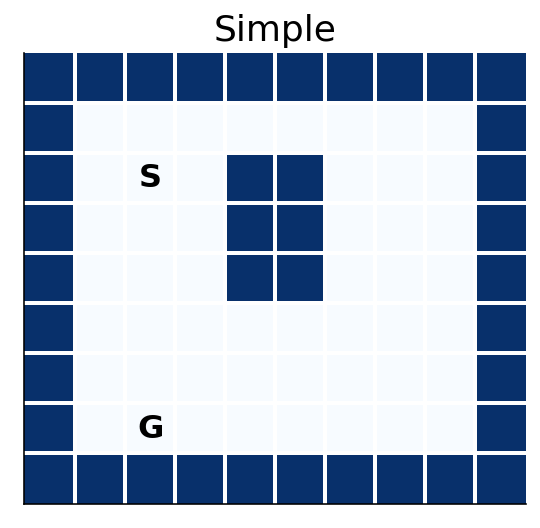

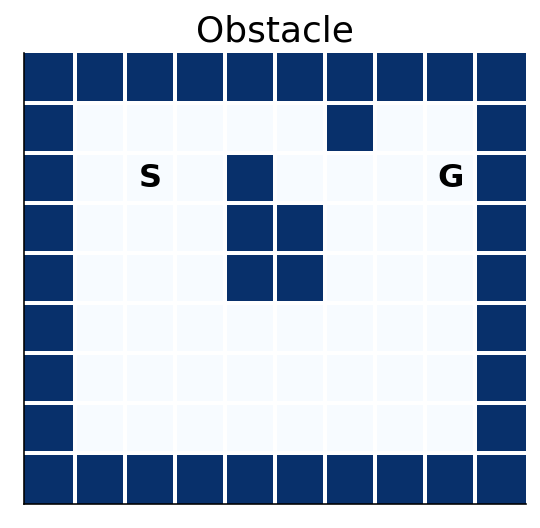

In [12]:
# Visualise GridWorlds

# Instantiate two tabular environments, a simple task, and one that involves
# the avoidance of an obstacle.
simple_grid = build_gridworld_task(
    task='simple', observation_type=ObservationType.GRID)
obstacle_grid = build_gridworld_task(
    task='obstacle', observation_type=ObservationType.GRID)

# Plot them.
simple_grid.plot_grid()
plt.title('Simple')

obstacle_grid.plot_grid()
plt.title('Obstacle')

In this environment, the agent has four possible  <font color='blue'>**actions**</font>: `up`, `right`, `down`, and `left`.  The <font color='green'>**reward**</font> is `-5` for bumping into a wall, `+10` for reaching the goal, and `0` otherwise. The episode ends when the agent reaches the goal, and otherwise continues. The **discount** on continuing steps, is $\gamma = 0.9$. 

Before we start building an agent to interact with this environment, let's first look at the types of objects the environment either returns (e.g., <font color='redorange'>**observations**</font>) or consumes (e.g., <font color='blue'>**actions**</font>). The `environment_spec` will show you the form of the <font color='redorange'>**observations**</font>, <font color='green'>**rewards**</font> and **discounts** that the environment exposes and the form of the <font color='blue'>**actions**</font> that can be taken.


In [13]:
# @title Look at `environment_spec`

# @markdown ##### **Note:** `setup_environment` is implemented in the same cell as GridWorld.
environment, environment_spec = setup_environment(simple_grid)

print('actions:\n', environment_spec.actions, '\n')
print('observations:\n', environment_spec.observations, '\n')
print('rewards:\n', environment_spec.rewards, '\n')
print('discounts:\n', environment_spec.discounts, '\n')

actions:
 DiscreteArray(shape=(), dtype=int32, name=action, minimum=0, maximum=3, num_values=4) 

observations:
 Array(shape=(9, 10, 3), dtype=dtype('float32'), name='observation_grid') 

rewards:
 Array(shape=(), dtype=dtype('float32'), name='reward') 

discounts:
 BoundedArray(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0) 




We first set the environment to its initial state by calling the `reset()` method which returns the first observation and resets the agent to the starting location.


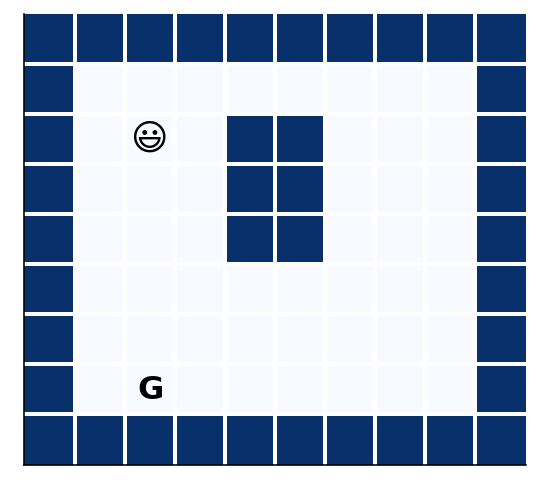

In [14]:
environment.reset()
environment.plot_state()

Now we want to take an action to interact with the environment. We do this by passing a valid action to the `dm_env.Environment.step()` method which returns a `dm_env.TimeStep` namedtuple with fields `(step_type, reward, discount, observation)`.

Let's take an action and visualise the resulting state of the grid-world. (You'll need to rerun the cell if you pick a new action.)

**Note for kaggle users:** As Kaggle does not render the forms automatically the students should be careful to notice the various instructions and manually play around with the values for the variables

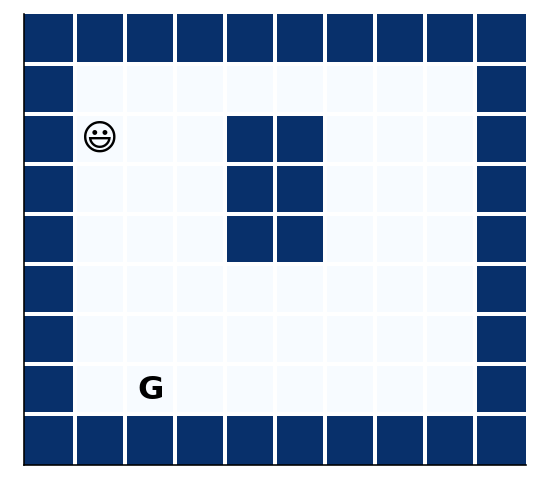

In [15]:
# @title Pick an action and see the state changing
action = "left" #@param ["up", "right", "down", "left"] {type:"string"}

action_int = {'up': 0,
              'right': 1,
              'down': 2,
              'left':3 }
action = int(action_int[action])
timestep = environment.step(action)  # pytype: dm_env.TimeStep
environment.plot_state()

In [16]:
# @title Run loop

# @markdown ##### This function runs an agent in the environment for a number of episodes, allowing it to learn.

# @markdown ##### *Double-click* to inspect the `run_loop` function.


def run_loop(environment,
             agent,
             num_episodes=None,
             num_steps=None,
             logger_time_delta=1.,
             label='training_loop',
             log_loss=False,
             ):
  """
  Perform the Acme run loop.
  Run the environment loop for `num_episodes` episodes. Each episode is itself
  a loop which interacts first with the environment to get an observation and
  then give that observation to the agent in order to retrieve an action. Upon
  termination of an episode a new episode will be started. If the number of
  episodes is not given then this will interact with the environment
  infinitely.

  Args:
    environment: dm_env 
      Used to generate trajectories.
    agent: acme.Actor 
      For selecting actions in the run loop.
    num_steps: Integer
      Number of steps to run the loop for. If `None` (default), runs
      without limit.
    num_episodes: Integer
      Nmber of episodes to run the loop for. If `None` (default),
      runs without limit.
    logger_time_delta: Float
      Time interval (in seconds) between consecutive logging steps.
    label: String
      Optional label used at logging steps.
    log_loss: Boolean
      If true, log_loss function is used to compute loss
      Else, use raw loss function

  Returns: 
    all_returns: List
      Log of return per episode
  """
  logger = loggers.TerminalLogger(label=label, time_delta=logger_time_delta)
  iterator = range(num_episodes) if num_episodes else itertools.count()
  all_returns = []

  num_total_steps = 0
  for episode in iterator:
    # Reset any counts and start the environment.
    start_time = time.time()
    episode_steps = 0
    episode_return = 0
    episode_loss = 0

    timestep = environment.reset()

    # Make the first observation.
    agent.observe_first(timestep)

    # Run an episode.
    while not timestep.last():
      # Generate an action from the agent's policy and step the environment.
      action = agent.select_action(timestep.observation)
      timestep = environment.step(action)

      # Have the agent observe the timestep and let the agent update itself.
      agent.observe(action, next_timestep=timestep)
      agent.update()

      # Book-keeping.
      episode_steps += 1
      num_total_steps += 1
      episode_return += timestep.reward

      if log_loss:
        episode_loss += agent.last_loss

      if num_steps is not None and num_total_steps >= num_steps:
        break

    # Collect the results and combine with counts.
    steps_per_second = episode_steps / (time.time() - start_time)
    result = {
        'episode': episode,
        'episode_length': episode_steps,
        'episode_return': episode_return,
    }
    if log_loss:
      result['loss_avg'] = episode_loss/episode_steps

    all_returns.append(episode_return)

    # Log the given results.
    logger.write(result)

    if num_steps is not None and num_total_steps >= num_steps:
      break
  return all_returns

In [17]:
# @title Implement the evaluation loop

# @markdown ##### This function runs the agent in the environment for a number of episodes, without allowing it to learn, in order to evaluate it.

# @markdown ##### *Double-click* to inspect the `evaluate` function.

def evaluate(environment: dm_env.Environment,
             agent: acme.Actor,
             evaluation_episodes: int):
  """
  Helper function to run evaluation loop

  Args: 
    environment: dm_env 
      Used to generate trajectories.
    agent: acme.Actor 
      For selecting actions in the run loop.
    evaluation_episodes: Integer
      Number of episodes for which evaluation loop is to be run for.

  Returns:
    frames: List
      Log of environment state for each time step. 
  """
  frames = []

  for episode in range(evaluation_episodes):
    timestep = environment.reset()
    episode_return = 0
    steps = 0
    while not timestep.last():
      frames.append(environment.plot_state(return_rgb=True))

      action = agent.select_action(timestep.observation)
      timestep = environment.step(action)
      steps += 1
      episode_return += timestep.reward
    print(
        f'Episode {episode} ended with reward {episode_return} in {steps} steps'
    )
  return frames

def display_video(frames: Sequence[np.ndarray],
                  filename: str = 'temp.mp4',
                  frame_rate: int = 12):
  """
  Save and render video.

  Args: 
    frames: Sequence[np.ndarray]
      Log of environment state for each time step.
    filename: String
      Name for the video file generated
    frame_rate: Integer
      Specifies frequency at which frames are displayed. 

  Returns: 
    IPython.display.HTML(video_tag)
  """
  # Write the frames to a video.
  with imageio.get_writer(filename, fps=frame_rate) as video:
    for frame in frames:
      video.append_data(frame)

  # Read video and display the video.
  video = open(filename, 'rb').read()
  b64_video = base64.b64encode(video)
  video_tag = ('<video  width="320" height="240" controls alt="test" '
               'src="data:video/mp4;base64,{0}">').format(b64_video.decode())
  return IPython.display.HTML(video_tag)

## Section 2.2: The Agent

We will be implementing Tabular & Function Approximation agents. Tabular agents are purely in Python.

All agents will share the same interface from the Acme `Actor`. Here we borrow a figure from Acme to show how this interaction occurs:


### Agent interface

<br>
<center><img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W3D2_BasicReinforcementLearning/static/actor_loop.png" width="500" /></center>

<br>

Each agent implements the following functions:

```python
class Agent(acme.Actor):
  def __init__(self, number_of_actions, number_of_states, ...):
    """ Provides the agent the number of actions and number of states. """

  def select_action(self, observation):
    """ Generates actions from observations. """

  def observe_first(self, timestep):
    """ Records the initial timestep in a trajectory. """
  
  def observe(self, action, next_timestep):
    """ Records the transition which occurred from taking an action. """

  def update(self):
    """ Updates the agent's internals to potentially change its behavior. """
```

Remarks on the `observe()` function:

1. In the last method, the `next_timestep` provides the `reward`, `discount`, and `observation` that resulted from selecting `action`.

2. The `next_timestep.step_type` will be either `MID` or `LAST` and should be used to determine whether this is the last observation in the episode.

3. The `next_timestep.step_type` cannot be `FIRST`; such a timestep should only ever be given to `observe_first()`.


### Coding Exercise 2.1: Random Agent

Below is a partially complete implemention of an agent that follows a random (non-learning) policy. Fill in the ```select_action``` method.

The ```select_action``` method should return a random **integer** between 0 and ```self._num_actions``` (not a tensor or an array!)

In [18]:
class RandomAgent(acme.Actor):
  """
  Initiates Acme Random Agent. 
  """

  def __init__(self, environment_spec):
    """
    Gets the number of available actions from the environment spec.

    Args:
      environment_spec: enum
        * actions: DiscreteArray(shape=(), dtype=int32, name=action, minimum=0, maximum=3, num_values=4) 
        * observations: Array(shape=(9, 10, 3), dtype=dtype('float32'), name='observation_grid') 
        * rewards: Array(shape=(), dtype=dtype('float32'), name='reward') 
        * discounts: BoundedArray(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0) 

    Returns: 
      Nothing
    """
    self._num_actions = environment_spec.actions.num_values

  def select_action(self, observation):
    """
    Selects an action uniformly at random.

    Args:
      observation_type: enum
        * ObservationType.STATE_INDEX: int32 index of agent occupied tile.
        * ObservationType.AGENT_ONEHOT: NxN float32 grid, with a 1 where the
          agent is and 0 elsewhere.
        * ObservationType.GRID: NxNx3 float32 grid of feature channels.
          First channel contains walls (1 if wall, 0 otherwise), second the
          agent position (1 if agent, 0 otherwise) and third goal position
          (1 if goal, 0 otherwise)
        * ObservationType.AGENT_GOAL_POS: float32 tuple with
          (agent_y, agent_x, goal_y, goal_x) 

    Returns: 
      action:
        Selected action (uniformly at random). 
    """
    #################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your implementation
    raise NotImplementedError("Student exercise: complete the select action method")
    #################################################
    # TODO return a random integer beween 0 and self._num_actions.
    # HINT: see the reference for how to sample a random integer in numpy:
    #   https://numpy.org/doc/1.16/reference/routines.random.html
    action = ...
    return action

  def observe_first(self, timestep):
    """ Does not record as the RandomAgent has no use for data. """
    pass

  def observe(self, action, next_timestep):
    """ Does not record as the RandomAgent has no use for data. """
    pass

  def update(self):
    """ Does not update as the RandomAgent does not learn from data. """
    pass


# Add event to airtable
atform.add_event('Coding Exercise 2.1: Random Agent')

In [19]:
# to_remove solution
class RandomAgent(acme.Actor):
  """
  Initiates Acme Random Agent. 
  """

  def __init__(self, environment_spec):
    """
    Gets the number of available actions from the environment spec.

    Args:
      environment_spec: enum
        * actions: DiscreteArray(shape=(), dtype=int32, name=action, minimum=0, maximum=3, num_values=4) 
        * observations: Array(shape=(9, 10, 3), dtype=dtype('float32'), name='observation_grid') 
        * rewards: Array(shape=(), dtype=dtype('float32'), name='reward') 
        * discounts: BoundedArray(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0) 

    Returns: 
      Nothing
    """
    self._num_actions = environment_spec.actions.num_values

  def select_action(self, observation):
    """
    Selects an action uniformly at random.

    Args:
      observation_type: enum
        * ObservationType.STATE_INDEX: int32 index of agent occupied tile.
        * ObservationType.AGENT_ONEHOT: NxN float32 grid, with a 1 where the
          agent is and 0 elsewhere.
        * ObservationType.GRID: NxNx3 float32 grid of feature channels.
          First channel contains walls (1 if wall, 0 otherwise), second the
          agent position (1 if agent, 0 otherwise) and third goal position
          (1 if goal, 0 otherwise)
        * ObservationType.AGENT_GOAL_POS: float32 tuple with
          (agent_y, agent_x, goal_y, goal_x) 

    Returns: 
      action: List
        Selected action (uniformly at random). 
    """
    # TODO return a random integer beween 0 and self._num_actions.
    # HINT: see the reference for how to sample a random integer in numpy:
    #   https://numpy.org/doc/1.16/reference/routines.random.html
    action = np.random.randint(self._num_actions)
    return action

  def observe_first(self, timestep):
    """ Does not record as the RandomAgent has no use for data. """
    pass

  def observe(self, action, next_timestep):
    """ Does not record as the RandomAgent has no use for data. """
    pass

  def update(self):
    """ Does not update as the RandomAgent does not learn from data. """
    pass


# Add event to airtable
atform.add_event('Coding Exercise 2.1: Random Agent')

In [20]:
# @title Visualisation of a random agent in GridWorld

# Create the agent by giving it the action space specification.
agent = RandomAgent(environment_spec)

# Run the agent in the evaluation loop, which returns the frames.
frames = evaluate(environment, agent, evaluation_episodes=1)

# Visualize the random agent's episode.
display_video(frames)

Episode 0 ended with reward -115.0 in 102 steps


---
# Section 3: The Bellman Equation

*Time estimate: ~15mins*

In [21]:
# @title Video 3: The Bellman Equation
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1Lv411E7CB", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"cLCoNBmYUns", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 3: The Bellman Equation')

display(out)



In this tutorial, we focus mainly on <font color='green'>**value based methods**</font>, where agents maintain a value for all state-action pairs and use those estimates to choose actions that maximize that <font color='green'>**value**</font> (instead of maintaining a policy directly, like in <font color='blue'>**policy gradient methods**</font>). 

We represent the <font color='green'>**action-value function**</font> (otherwise known as $\color{green}Q$-function associated with following/employing a policy $\pi$ in a given MDP as:

\begin{equation}
\color{green}Q^{\color{blue}{\pi}}(\color{red}{s},\color{blue}{a}) = \mathbb{E}_{\tau \sim P^{\color{blue}{\pi}}} \left[ \sum_t \gamma^t \color{green}{r_t}| s_0=\color{red}s,a_0=\color{blue}{a} \right]
\end{equation}

where $\tau = \{\color{red}{s_0}, \color{blue}{a_0}, \color{green}{r_0}, \color{red}{s_1}, \color{blue}{a_1}, \color{green}{r_1}, \cdots \}$


Recall that efficient value estimations are based on the famous **_Bellman Expectation Equation_**:

\begin{equation}
\color{green}Q^\color{blue}{\pi}(\color{red}{s},\color{blue}{a}) =    \sum_{\color{red}{s'}\in \color{red}{\mathcal{S}}} 
\color{purple}P(\color{red}{s'} |\color{red}{s},\color{blue}{a})
\left(
  \color{green}{R}(\color{red}{s},\color{blue}{a}, \color{red}{s'}) 
  + \gamma \color{green}V^\color{blue}{\pi}(\color{red}{s'}) 
  \right)
\end{equation}

where $\color{green}V^\color{blue}{\pi}$ is the expected $\color{green}Q^\color{blue}{\pi}$ value for a particular state, i.e. $\color{green}V^\color{blue}{\pi}(\color{red}{s}) = \sum_{\color{blue}{a} \in \color{blue}{\mathcal{A}}} \color{blue}{\pi}(\color{blue}{a} |\color{red}{s}) \color{green}Q^\color{blue}{\pi}(\color{red}{s},\color{blue}{a})$.


---
# Section 4: Policy Evaluation

*Time estimate: ~30mins*

In [22]:
# @title Video 4: Policy Evaluation
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV15f4y157zA", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"HAxR4SuaZs4", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 4: Policy Evaluation')

display(out)

### Lecture footnotes: 

**Episodic vs non-episodic environments:** Up until now, we've mainly been talking about episodic environments, or environments that terminate and reset (resampled) after a finite number of steps. However, there are also *non-episodic* environments, in which an agent cannot count on the environment resetting. Thus, they are forced to learn in a *continual* fashion.

**Policy iteration vs value iteration:** Compare the two equations below, noting that the only difference is that in value iteration, the second sum is replaced by a max.

*Policy iteration (using Bellman expectation equation)*
\begin{equation}
\color{green}Q_\color{green}{k}(\color{red}{s},\color{blue}{a}) \leftarrow  \color{green}{R}(\color{red}{s},\color{blue}{a}) +\gamma \sum_{\color{red}{s'}\in \color{red}{\mathcal{S}}} 
\color{purple}P(\color{red}{s'} |\color{red}{s},\color{blue}{a})
\sum_{\color{blue}{a'} \in \color{blue}{\mathcal{A}}} \color{blue}{\pi_{k-1}}(\color{blue}{a'} |\color{red}{s'}) \color{green}{Q_{k-1}}(\color{red}{s'},\color{blue}{a'})
\end{equation}

*Value iteration (using Bellman optimality equation)*
\begin{equation}
\color{green}Q_\color{green}{k}(\color{red}{s},\color{blue}{a}) \leftarrow  \color{green}{R}(\color{red}{s},\color{blue}{a}) +\gamma \sum_{\color{red}{s'}\in \color{red}{\mathcal{S}}} 
\color{purple}P(\color{red}{s'} |\color{red}{s},\color{blue}{a})
\max_{\color{blue}{a'}} \color{green}{Q_{k-1}}(\color{red}{s'},\color{blue}{a'})
\end{equation}

### Coding Exercise 4.1 Policy Evaluation Agent


Tabular agents implement a function `q_values()` returning a matrix of Q values
of shape: (`number_of_states`, `number_of_actions`)

In this section, we will implement a `PolicyEvalAgent` as an ACME actor: given an `evaluation_policy` $\pi_e$ and a `behaviour_policy` $\pi_b$, it will use the `behaviour_policy` to choose actions, and it will use the corresponding trajectory data to evaluate the `evaluation_policy` (i.e. compute the Q-values as if you were following the `evaluation_policy`). 

Algorithm:

**Initialize** $Q(\color{red}{s}, \color{blue}{a})$ for all $\color{red}{s}$ ∈ $\mathcal{\color{red}S}$ and $\color{blue}a$ ∈ $\mathcal{\color{blue}A}(\color{red}s)$

**Loop forever**:

1. $\color{red}{s} \gets{}$current (nonterminal) state
 
2. $\color{blue}{a} \gets{} \text{behaviour_policy }\pi_b(\color{red}s)$
 
3. Take action $\color{blue}{a}$; observe resulting reward $\color{green}{r}$, discount $\gamma$, and state, $\color{red}{s'}$

4. Compute TD-error: $\delta = \color{green}R + \gamma Q(\color{red}{s'}, \underbrace{\pi_e(\color{red}{s'}}_{\color{blue}{a'}})) − Q(\color{red}s, \color{blue}a)$

4. Update Q-value with a small $\alpha$ step: $Q(\color{red}s, \color{blue}a) \gets Q(\color{red}s, \color{blue}a) + \alpha \delta$


We will use a uniform `random policy` as our `evaluation policy` here, but you could replace this with any policy you want, such as a greedy one.

In [23]:
# Uniform random policy
def random_policy(q):
  return np.random.randint(4)

In [24]:
class PolicyEvalAgent(acme.Actor):
  """
  New Acme agent that behaves according to uniform random policy.
  """
  
  def __init__(self, environment_spec, evaluated_policy,
               behaviour_policy=random_policy, step_size=0.1):
    """
    Initiates the agent

    Args: 
      environment_spec: enum
        * actions: DiscreteArray(shape=(), dtype=int32, name=action, minimum=0, maximum=3, num_values=4) 
        * observations: Array(shape=(9, 10, 3), dtype=dtype('float32'), name='observation_grid') 
        * rewards: Array(shape=(), dtype=dtype('float32'), name='reward') 
        * discounts: BoundedArray(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0) 
      evaluated_policy: f.__name__
        Policy on which agent is to be evaluated
      behavior policy: f.__name__
        Uniform random policy
      step_size: Float
        Size of step while choosing action
      
    Returns: 
      Nothing       
    """
    self._state = None
    # Get number of states and actions from the environment spec.
    self._number_of_states = environment_spec.observations.num_values
    self._number_of_actions = environment_spec.actions.num_values
    self._step_size = step_size
    self._behaviour_policy = behaviour_policy
    self._evaluated_policy = evaluated_policy
    #################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your implementation
    raise NotImplementedError("Initialize your Q-values!")
    #################################################
    # TODO Initialize the Q-values to be all zeros.
    # (Note: can also be random, but we use zeros here for reproducibility)
    # HINT: This is a table of state and action pairs, so needs to be a 2-D
    #   array. See the reference for how to create this in numpy:
    #   https://numpy.org/doc/stable/reference/generated/numpy.zeros.html
    self._q = ...
    self._action = None
    self._next_state = None

  @property
  def q_values(self):
    # Return the Q values
    return self._q

  def select_action(self, observation):
    # Select an action
    return self._behaviour_policy(self._q[observation])

  def observe_first(self, timestep):
    self._state = timestep.observation

  def observe(self, action, next_timestep):
    """
    Function to compute TD Error

    Args: 
      action: Integer
        Selected action based on Q value
      next_timestep: dm_env._environment.TimeStep
        Advances timestep

    Returns:
      Nothing
    """
    s = self._state
    a = action
    r = next_timestep.reward
    g = next_timestep.discount
    next_s = next_timestep.observation

    # Compute TD-Error.
    self._action = a
    self._next_state = next_s
    #################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your implementation
    raise NotImplementedError("Need to select the next action")
    #################################################
    # TODO Select the next action from the evaluation policy
    # HINT: Refer to step 4 of the algorithm above.
    next_a = ...
    self._td_error = r + g * self._q[next_s, next_a] - self._q[s, a]

  def update(self):
    """
    Perform update based on Q-table

    Args: 
      None
    
    Returns: 
      Nothing
    """
    # Updates
    s = self._state
    a = self._action
    # Q-value table update.
    self._q[s, a] += self._step_size * self._td_error
    # Update the state
    self._state = self._next_state


# Add event to airtable
atform.add_event('Coding Exercise 4.1 Policy Evaluation Agent')

In [25]:
# to_remove solution
class PolicyEvalAgent(acme.Actor):
  """
  New Acme agent that behaves according to uniform random policy.
  """
  
  def __init__(self, environment_spec, evaluated_policy,
               behaviour_policy=random_policy, step_size=0.1):
    """
    Initiates the agent

    Args: 
      environment_spec: enum
        * actions: DiscreteArray(shape=(), dtype=int32, name=action, minimum=0, maximum=3, num_values=4) 
        * observations: Array(shape=(9, 10, 3), dtype=dtype('float32'), name='observation_grid') 
        * rewards: Array(shape=(), dtype=dtype('float32'), name='reward') 
        * discounts: BoundedArray(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0) 
      evaluated_policy: f.__name__
        Policy on which agent is to be evaluated
      behavior policy: f.__name__
        Uniform random policy
      step_size: Float
        Size of step while choosing action
      
    Returns: 
      Nothing       
    """
    self._state = None
    # Get number of states and actions from the environment spec.
    self._number_of_states = environment_spec.observations.num_values
    self._number_of_actions = environment_spec.actions.num_values
    self._step_size = step_size
    self._behaviour_policy = behaviour_policy
    self._evaluated_policy = evaluated_policy
    # TODO Initialize the Q-values to be all zeros.
    # (Note: can also be random, but we use zeros here for reproducibility)
    # HINT: This is a table of state and action pairs, so needs to be a 2-D
    #   array. See the reference for how to create this in numpy:
    #   https://numpy.org/doc/stable/reference/generated/numpy.zeros.html
    self._q = np.zeros((self._number_of_states, self._number_of_actions))
    self._action = None
    self._next_state = None

  @property
  def q_values(self):
    # Return the Q values
    return self._q

  def select_action(self, observation):
    # Select an action
    return self._behaviour_policy(self._q[observation])

  def observe_first(self, timestep):
    self._state = timestep.observation

  def observe(self, action, next_timestep):
    """
    Function to compute TD Error

    Args: 
      action: Integer
        Selected action based on Q value
      next_timestep: dm_env._environment.TimeStep
        Advances timestep

    Returns:
      Nothing
    """
    s = self._state
    a = action
    r = next_timestep.reward
    g = next_timestep.discount
    next_s = next_timestep.observation

    # Compute TD-Error.
    self._action = a
    self._next_state = next_s
    # TODO Select the next action from the evaluation policy
    # HINT: Refer to step 4 of the algorithm above.
    next_a = self._evaluated_policy(self._q[next_s])
    self._td_error = r + g * self._q[next_s, next_a] - self._q[s, a]

  def update(self):
    """
    Perform update based on Q-table

    Args: 
      None
    
    Returns: 
      Nothing
    """
    # Updates
    s = self._state
    a = self._action
    # Q-value table update.
    self._q[s, a] += self._step_size * self._td_error
    # Update the state
    self._state = self._next_state


# Add event to airtable
atform.add_event('Coding Exercise 4.1 Policy Evaluation Agent')

AFTER 1000.0 STEPS ...


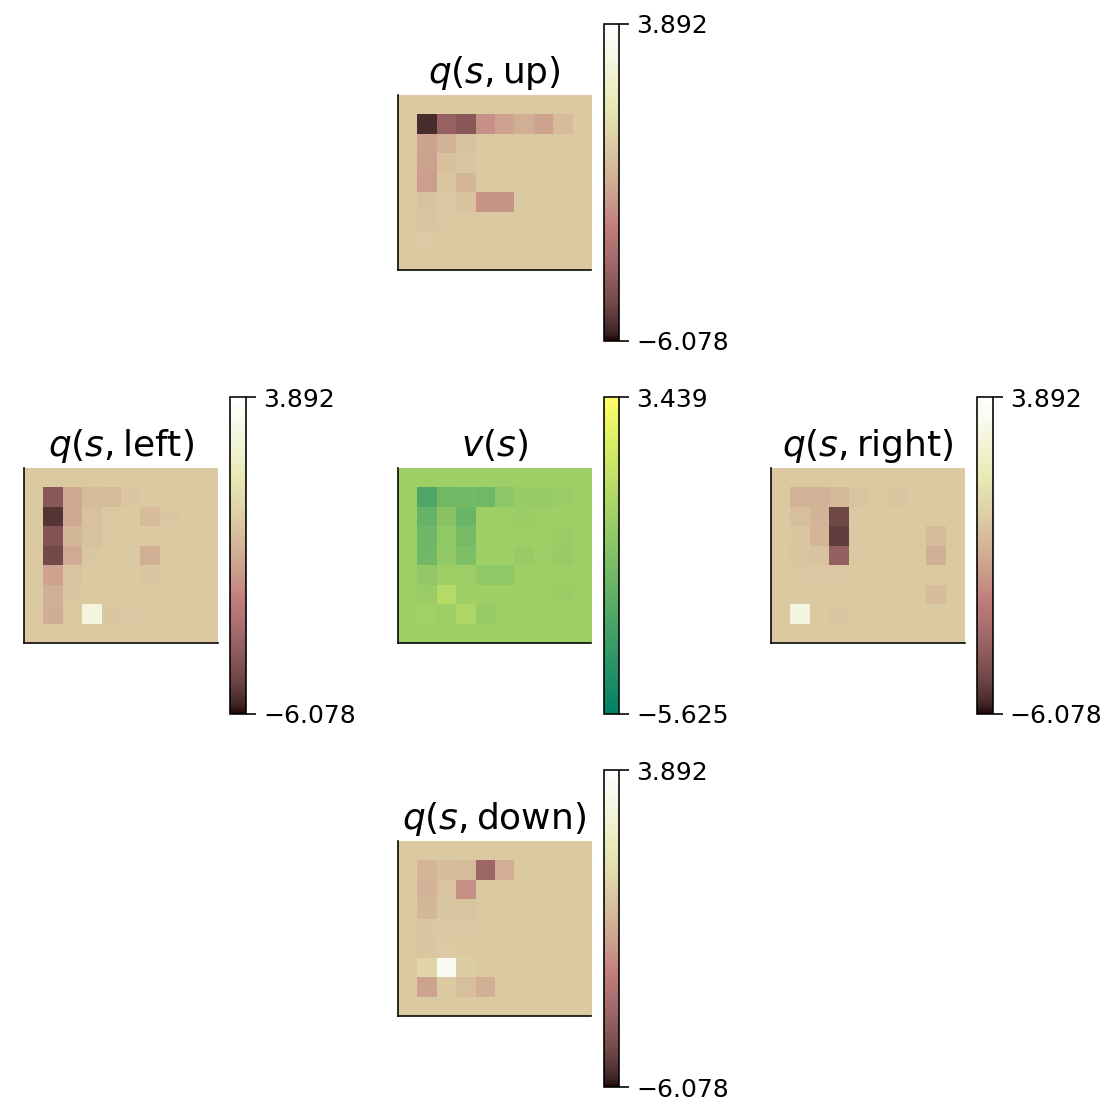

In [26]:
# @title Perform policy evaluation

# @markdown ##### Here you can visualize the state value and action-value functions for the "simple" task.

num_steps = 1e3

# Create the environment
grid = build_gridworld_task(task='simple')
environment, environment_spec = setup_environment(grid)

# Create the policy evaluation agent to evaluate a random policy.
agent = PolicyEvalAgent(environment_spec, evaluated_policy=random_policy)

# Run experiment and get the value functions from agent
returns = run_loop(environment=environment, agent=agent, num_steps=int(num_steps))

# Get the q-values
q = agent.q_values.reshape(grid._layout.shape + (4, ))

# Visualize value functions
print('AFTER {} STEPS ...'.format(num_steps))
plot_action_values(q, epsilon=1.)

---
# Section 5: Tabular Value-Based Model-Free Learning

*Time estimate: ~50mins*

In [27]:
# @title Video 5: Model-Free Learning
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1iU4y1n7M6", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"Y4TweUYnexU", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 5: Model-Free Learning')

display(out)

### Lecture footnotes: 

**On-policy (SARSA) vs off-policy (Q-learning) TD control:** Compare the two equations below and see that the only difference is that for Q-learning, the update is performed assuming that a greedy policy is followed, which is not the one used to collect the data, hence the name *off-policy*. 

*SARSA*
\begin{equation}
\color{green}Q(\color{red}{s},\color{blue}{a}) \leftarrow  \color{green}Q(\color{red}{s},\color{blue}{a}) +\alpha(\color{green}{r} + \gamma\color{green}{Q}(\color{red}{s'},\color{blue}{a'}) - \color{green}{Q}(\color{red}{s},\color{blue}{a}))
\end{equation}

*Q-learning*
\begin{equation}
\color{green}Q(\color{red}{s},\color{blue}{a}) \leftarrow  \color{green}Q(\color{red}{s},\color{blue}{a}) +\alpha(\color{green}{r} + \gamma\max_{\color{blue}{a'}} \color{green}{Q}(\color{red}{s'},\color{blue}{a'}) - \color{green}{Q}(\color{red}{s},\color{blue}{a}))
\end{equation}

## Section 5.1: On-policy control: SARSA Agent
In this section, we are focusing on control RL algorithms, which perform the **evaluation** and **improvement** of the policy synchronously. That is, the policy that is being evaluated improves as the agent is using it to interact with the environent.


The first algorithm we are going to be looking at is SARSA. This is an **on-policy algorithm** -- i.e: the data collection is done by leveraging the policy we're trying to optimize. 

As discussed during lectures, a greedy policy with respect to a given $\color{Green}Q$ fails to explore the environment as needed; we will use instead an $\epsilon$-greedy policy with respect to $\color{Green}Q$.

### SARSA Algorithm

**Input:**
- $\epsilon \in (0, 1)$ the probability of taking a random action , and
- $\alpha > 0$ the step size, also known as learning rate.

**Initialize:** $\color{green}Q(\color{red}{s}, \color{blue}{a})$ for all $\color{red}{s}$ ∈ $\mathcal{\color{red}S}$ and $\color{blue}a$ ∈ $\mathcal{\color{blue}A}$

**Loop forever:**

1. Get $\color{red}s \gets{}$current (non-terminal) state
 
2. Select $\color{blue}a \gets{} \text{epsilon_greedy}(\color{green}Q(\color{red}s, \cdot))$
 
3. Step in the environment by passing the selected action $\color{blue}a$

4. Observe resulting reward $\color{green}r$, discount $\gamma$, and state $\color{red}{s'}$

5. Compute TD error: $\Delta \color{green}Q \gets 
\color{green}r + \gamma \color{green}Q(\color{red}{s'}, \color{blue}{a'}) − \color{green}Q(\color{red}s, \color{blue}a)$, <br> where $\color{blue}{a'} \gets \text{epsilon_greedy}(\color{green}Q(\color{red}{s'}, \cdot))$

5. Update $\color{green}Q(\color{red}s, \color{blue}a) \gets \color{green}Q(\color{red}s, \color{blue}a) + \alpha \Delta \color{green}Q$


### Coding Exercise 5.1: Implement $\epsilon$-greedy
Below you will find incomplete code for sampling from an $\epsilon$-greedy policy, to be used later when we implement an agent that learns values according to the SARSA algorithm.




In [28]:
def epsilon_greedy(
    q_values_at_s: np.ndarray, 
    epsilon: float = 0.1 
    ):
  """
  Return an epsilon-greedy action sample 

  Args:
    q_values_at_s: np.ndarray
      Q-values in state s: Q(s, a).
    epsilon: float
      Probability of taking a random action.

  Returns: 
    action: Integer
      Chosen action based on epsilon-greedy policy
  """
  #################################################
  # Fill in missing code below (...),
  # then remove or comment the line below to test your implementation
  raise NotImplementedError("Student exercise: complete epsilon greedy policy function")
  #################################################
  # TODO generate a uniform random number and compare it to epsilon to decide if
  # the action should be greedy or not
  # HINT: Use np.random.random() to generate a random float from 0 to 1.
  if ...:
    #TODO Greedy: Pick action with the largest Q-value.
    action = ...
  else:
    # Get the number of actions from the size of the given vector of Q-values.
    num_actions = np.array(q_values_at_s).shape[-1]
    # TODO else return a random action
    # HINT: Use np.random.randint() to generate a random integer.
    action = ...

  return action


# Add event to airtable
atform.add_event('Coding Exercise 5.1: Implement epsilon-greedy')

In [29]:
# to_remove solution
def epsilon_greedy(
    q_values_at_s: np.ndarray, 
    epsilon: float = 0.1 
    ):
  """
  Return an epsilon-greedy action sample 
  Args:
    q_values_at_s: np.ndarray
      Q-values in state s: Q(s, a).
    epsilon: float
      Probability of taking a random action.
  Returns: 
    action: Integer
      Chosen action based on epsilon-greedy policy
  """
  # TODO generate a uniform random number and compare it to epsilon to decide if
  # the action should be greedy or not
  # HINT: Use np.random.random() to generate a random float from 0 to 1.
  if epsilon < np.random.random():
    #TODO Greedy: Pick action with the largest Q-value.
    action = np.argmax(q_values_at_s)
  else:
    # Get the number of actions from the size of the given vector of Q-values.
    num_actions = np.array(q_values_at_s).shape[-1]
    # TODO else return a random action
    # HINT: Use np.random.randint() to generate a random integer.
    action = np.random.randint(num_actions)
    
  return action


# Add event to airtable
atform.add_event('Coding Exercise 5.1: Implement epsilon-greedy')

In [30]:
# @title Sample action from $\epsilon$-greedy
# @markdown ##### With $\epsilon=0.5$, you should see that about half the time, you will get back the optimal action 3, but half the time, it will be random.

# Create fake q-values
q_values = np.array([0, 0, 0, 1])

# Set epsilon = 0.5
epsilon = 0.5
action = epsilon_greedy(q_values, epsilon=epsilon)
print(action)

0


### Coding Exercise 5.2: Run your SARSA agent on the `obstacle` environment

This environment is similar to the Cliff-walking example from [Sutton & Barto](http://incompleteideas.net/book/RLbook2018.pdf) and allows us to see the different policies learned by on-policy vs off-policy methods. Try varying the number of steps.

In [31]:
class SarsaAgent(acme.Actor):
  """
  Create SARSA Agent (State–action–reward–state–action)
  """
  
  def __init__(self,
               environment_spec: specs.EnvironmentSpec,
               epsilon: float,
               step_size: float = 0.1
               ):
    """
    Initiates SARSA Agent

    Args: 
      environment_spec: enum
        * actions: DiscreteArray(shape=(), dtype=int32, name=action, minimum=0, maximum=3, num_values=4) 
        * observations: Array(shape=(9, 10, 3), dtype=dtype('float32'), name='observation_grid') 
        * rewards: Array(shape=(), dtype=dtype('float32'), name='reward') 
        * discounts: BoundedArray(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0) 
      epsilon: Float 
        Sets the exploitation-exploration control hyperparameter
      step_size: Float 
        Size of step while choosing action [default: 0.1]

    Returns:
      Nothing
    """
    # Get number of states and actions from the environment spec.
    self._num_states = environment_spec.observations.num_values
    self._num_actions = environment_spec.actions.num_values

    # Create the table of Q-values, all initialized at zero.
    self._q = np.zeros((self._num_states, self._num_actions))

    # Store algorithm hyper-parameters.
    self._step_size = step_size
    self._epsilon = epsilon

    # Containers you may find useful.
    self._state = None
    self._action = None
    self._next_state = None

  @property
  def q_values(self):
    return self._q

  def select_action(self, observation):
    return epsilon_greedy(self._q[observation], self._epsilon)

  def observe_first(self, timestep):
    # Set current state.
    self._state = timestep.observation

  def observe(self, action, next_timestep):
    """
    Function to on-policy Q-value update

    Args: 
      action: Integer
        Selected action based on Q value
      next_timestep: dm_env._environment.TimeStep
        Advances timestep

    Returns:
      Nothing
    """
    # Unpacking the timestep to lighten notation.
    s = self._state
    a = action
    r = next_timestep.reward
    g = next_timestep.discount
    next_s = next_timestep.observation
    # Compute the action that would be taken from the next state.
    next_a = self.select_action(next_s)
    # Compute the on-policy Q-value update.
    self._action = a
    self._next_state = next_s
    #################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your implementation
    raise NotImplementedError("Student exercise: complete the on-policy Q-value update")
    #################################################
    # TODO complete the line below to compute the temporal difference error
    # HINT: see step 5 in the pseudocode above.
    self._td_error = ...

  def update(self):
    """
    Perform update based on Q-table

    Args: 
      None
    
    Returns: 
      Nothing
    """
    # Optional unpacking to lighten notation.
    s = self._state
    a = self._action
    #################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your implementation
    raise NotImplementedError("Student exercise: complete value update")
    #################################################
    # Update the Q-value table value at (s, a).
    # TODO: Update the Q-value table value at (s, a).
    # HINT: see step 6 in the pseudocode above, remember that alpha = step_size!
    self._q[s, a] += ...
    # Update the current state.
    self._state = self._next_state


# Add event to airtable
atform.add_event('Coding Exercise 5.2: Run your SARSA agent on the obstacle environment')

In [32]:
# to_remove solution
class SarsaAgent(acme.Actor):
  """
  Create SARSA Agent (State–action–reward–state–action)
  """
  def __init__(self,
               environment_spec: specs.EnvironmentSpec,
               epsilon: float,
               step_size: float = 0.1
               ):
    """
    Initiates SARSA Agent
    Args: 
      environment_spec: enum
        * actions: DiscreteArray(shape=(), dtype=int32, name=action, minimum=0, maximum=3, num_values=4) 
        * observations: Array(shape=(9, 10, 3), dtype=dtype('float32'), name='observation_grid') 
        * rewards: Array(shape=(), dtype=dtype('float32'), name='reward') 
        * discounts: BoundedArray(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0) 
      epsilon: Float 
        Sets the exploitation-exploration control hyperparameter
      step_size: Float 
        Size of step while choosing action [default: 0.1]
    Returns:
      Nothing
    """
    # Get number of states and actions from the environment spec.
    self._num_states = environment_spec.observations.num_values
    self._num_actions = environment_spec.actions.num_values
    # Create the table of Q-values, all initialized at zero.
    self._q = np.zeros((self._num_states, self._num_actions))
    # Store algorithm hyper-parameters.
    self._step_size = step_size
    self._epsilon = epsilon
    # Containers you may find useful.
    self._state = None
    self._action = None
    self._next_state = None

  @property
  def q_values(self):
    return self._q

  def select_action(self, observation):
    return epsilon_greedy(self._q[observation], self._epsilon)

  def observe_first(self, timestep):
    # Set current state.
    self._state = timestep.observation

  def observe(self, action, next_timestep):
    """
    Function to on-policy Q-value update

    Args: 
      action: Integer
        Selected action based on Q value
      next_timestep: dm_env._environment.TimeStep
        Advances timestep

    Returns:
      Nothing
    """
    # Unpacking the timestep to lighten notation.
    s = self._state
    a = action
    r = next_timestep.reward
    g = next_timestep.discount
    next_s = next_timestep.observation
    # Compute the action that would be taken from the next state.
    next_a = self.select_action(next_s)
    # Compute the on-policy Q-value update.
    self._action = a
    self._next_state = next_s
    # TODO complete the line below to compute the temporal difference error
    # HINT: see step 5 in the pseudocode above.
    self._td_error = r + g * self._q[next_s, next_a] - self._q[s, a]


  def update(self):
    """
    Perform update based on Q-table

    Args: 
      None
    
    Returns: 
      Nothing
    """
    # Optional unpacking to lighten notation.
    s = self._state
    a = self._action
    # Update the Q-value table value at (s, a).
    # TODO: Update the Q-value table value at (s, a).
    # HINT: see step 6 in the pseudocode above, remember that alpha = step_size!
    self._q[s, a] += self._step_size * self._td_error
    # Update the current state.
    self._state = self._next_state


# Add event to airtable
atform.add_event('Coding Exercise 5.2: Run your SARSA agent on the obstacle environment')

AFTER 100,000 STEPS ...


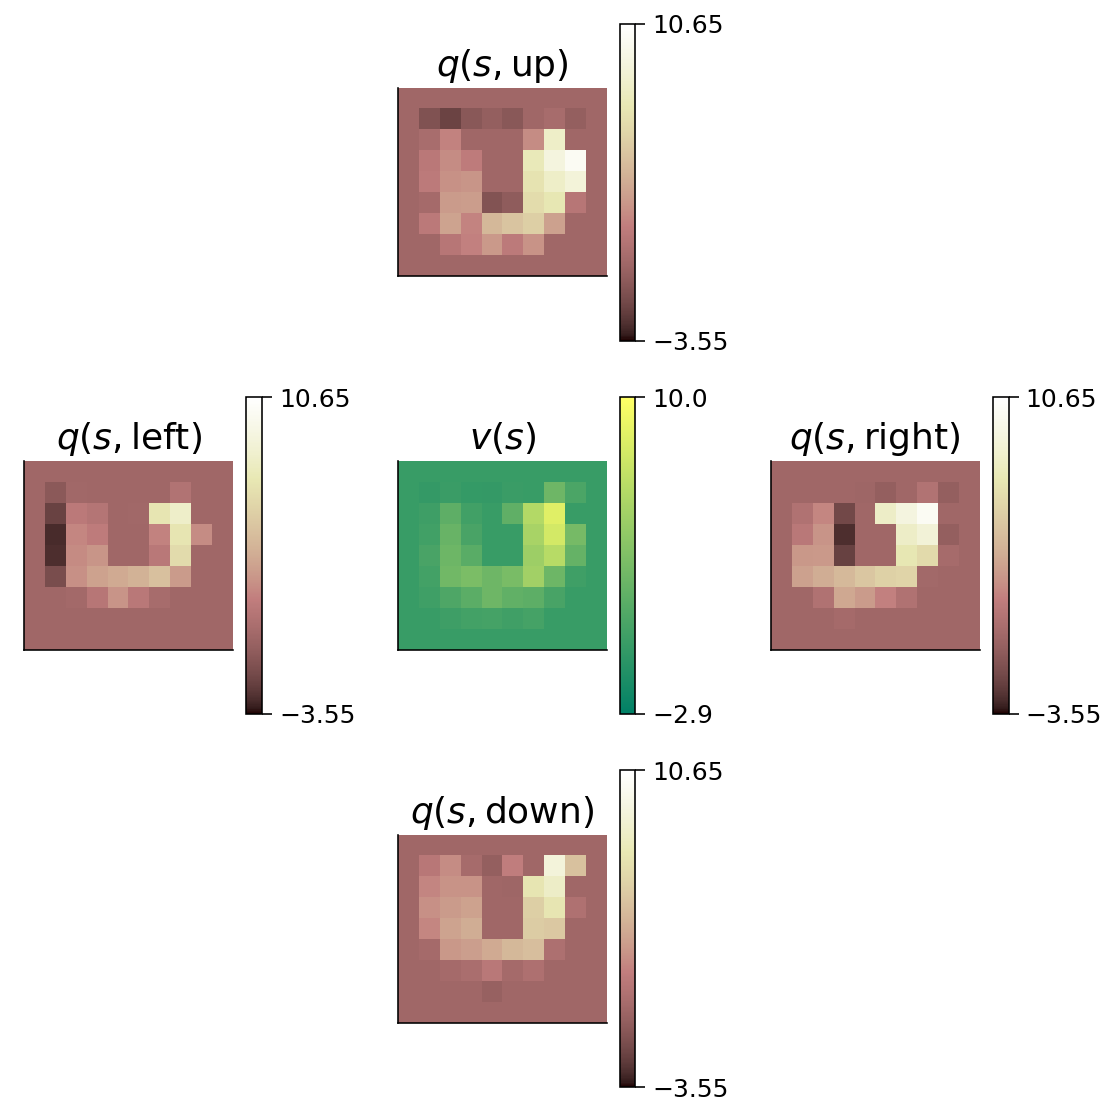

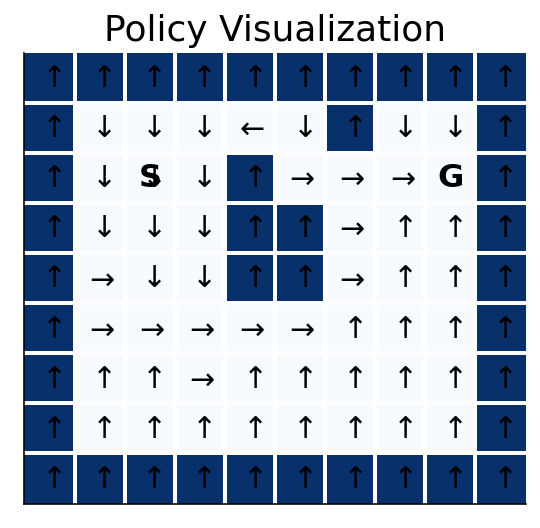

In [33]:
# @title Run SARSA agent and visualize value function

num_steps = 1e5 # @param {type:"number"}
num_steps = int(num_steps)

# Create the environment.
grid = build_gridworld_task(task='obstacle')
environment, environment_spec = setup_environment(grid)

# Create the agent.
agent = SarsaAgent(environment_spec, epsilon=0.1, step_size=0.1)

# Run the experiment and get the value functions from agent
returns = run_loop(environment=environment, agent=agent, num_steps=num_steps)
print('AFTER {0:,} STEPS ...'.format(num_steps))

# Get the Q-values and reshape them to recover grid-like structure of states.
q_values = agent.q_values
grid_shape = grid.layout.shape
q_values = q_values.reshape([*grid_shape, -1])

# Visualize the value and Q-value tables.
plot_action_values(q_values, epsilon=1.)

# Visualize the greedy policy.
environment.plot_greedy_policy(q_values)

## Section 5.2 Off-policy control: Q-learning Agent
Reminder: $\color{green}Q$-learning is a very powerful and general algorithm, that enables control (figuring out the optimal policy/value function) both on and off-policy.

**Initialize** $\color{green}Q(\color{red}{s}, \color{blue}{a})$ for all $\color{red}{s} \in \color{red}{\mathcal{S}}$ and $\color{blue}{a} \in \color{blue}{\mathcal{A}}$

**Loop forever**:

1. Get $\color{red}{s} \gets{}$current (non-terminal) state
 
2. Select $\color{blue}{a} \gets{} \text{behaviour_policy}(\color{red}{s})$
 
3. Step in the environment by passing the selected action $\color{blue}{a}$

4. Observe resulting reward $\color{green}{r}$, discount $\gamma$, and state, $\color{red}{s'}$

5. Compute the TD error: $\Delta \color{green}Q \gets \color{green}{r} + \gamma \color{green}Q(\color{red}{s'}, \color{blue}{a'}) − \color{green}Q(\color{red}{s}, \color{blue}{a})$, <br>
where $\color{blue}{a'} \gets \arg\max_{\color{blue}{\mathcal A}} \color{green}Q(\color{red}{s'}, \cdot)$

6. Update $\color{green}Q(\color{red}{s}, \color{blue}{a}) \gets \color{green}Q(\color{red}{s}, \color{blue}{a}) + \alpha \Delta \color{green}Q$

Notice that the actions $\color{blue}{a}$ and $\color{blue}{a'}$ are not selected using the same policy, hence this algorithm being **off-policy**.

### Coding Exercise 5.3: Implement Q-Learning


In [34]:
QValues = np.ndarray
Action = int

# A value-based policy takes the Q-values at a state and returns an action.
ValueBasedPolicy = Callable[[QValues], Action]


class QLearningAgent(acme.Actor):
  """
  Build QLearning Agent
  """
  
  def __init__(self,
               environment_spec: specs.EnvironmentSpec,
               behaviour_policy: ValueBasedPolicy,
               step_size: float = 0.1):
    """
    Initiates QLearning Agent

    Args: 
      environment_spec: enum
        * actions: DiscreteArray(shape=(), dtype=int32, name=action, minimum=0, maximum=3, num_values=4) 
        * observations: Array(shape=(9, 10, 3), dtype=dtype('float32'), name='observation_grid') 
        * rewards: Array(shape=(), dtype=dtype('float32'), name='reward') 
        * discounts: BoundedArray(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0) 
      behaviour_policy: f.__name__ 
        Policy based on which agent behaves
      step_size: Float 
        Size of step while choosing action [default: 0.1]

    Returns:
      Nothing
    """
    # Get number of states and actions from the environment spec.
    self._num_states = environment_spec.observations.num_values
    self._num_actions = environment_spec.actions.num_values

    # Create the table of Q-values, all initialized at zero.
    self._q = np.zeros((self._num_states, self._num_actions))

    # Store algorithm hyper-parameters.
    self._step_size = step_size

    # Store behavior policy.
    self._behaviour_policy = behaviour_policy

    # Containers you may find useful.
    self._state = None
    self._action = None
    self._next_state = None

  @property
  def q_values(self):
    return self._q

  def select_action(self, observation):
    return self._behaviour_policy(self._q[observation])

  def observe_first(self, timestep):
    # Set current state.
    self._state = timestep.observation

  def observe(self, action, next_timestep):
    """
    Function to compute TD Error

    Args: 
      action: Integer
        Selected action based on Q value
      next_timestep: dm_env._environment.TimeStep
        Advances timestep

    Returns:
      Nothing
    """
    # Unpacking the timestep to lighten notation.
    s = self._state
    a = action
    r = next_timestep.reward
    g = next_timestep.discount
    next_s = next_timestep.observation

    # Compute the TD error.
    self._action = a
    self._next_state = next_s
    #################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your implementation
    raise NotImplementedError("Student exercise: complete the off-policy Q-value update")
    #################################################
    # TODO complete the line below to compute the temporal difference error
    # HINT: This is very similar to what we did for SARSA, except keep in mind
    # that we're now taking a max over the q-values (see lecture footnotes above).
    # You will find the function np.max() useful.
    self._td_error = ...

  def update(self):
    """
    Perform update based on Q-table

    Args: 
      None
    
    Returns: 
      Nothing
    """
    # Optional unpacking to lighten notation.
    s = self._state
    a = self._action
    #################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your implementation
    raise NotImplementedError("Student exercise: complete value update")
    #################################################
    # Update the Q-value table value at (s, a).
    # TODO: Update the Q-value table value at (s, a).
    # HINT: see step 6 in the pseudocode above, remember that alpha = step_size!
    self._q[...] += ...
    # Update the current state.
    self._state = self._next_state


# Add event to airtable
atform.add_event('Coding Exercise 5.3: Implement Q-Learning')

In [35]:
# to_remove solution
QValues = np.ndarray
Action = int

# A value-based policy takes the Q-values at a state and returns an action.
ValueBasedPolicy = Callable[[QValues], Action]


class QLearningAgent(acme.Actor):
  """
  Build QLearning Agent
  """

  def __init__(self,
               environment_spec: specs.EnvironmentSpec,
               behaviour_policy: ValueBasedPolicy,
               step_size: float = 0.1):
    """
    Initiates QLearning Agent

    Args: 
      environment_spec: enum
        * actions: DiscreteArray(shape=(), dtype=int32, name=action, minimum=0, maximum=3, num_values=4) 
        * observations: Array(shape=(9, 10, 3), dtype=dtype('float32'), name='observation_grid') 
        * rewards: Array(shape=(), dtype=dtype('float32'), name='reward') 
        * discounts: BoundedArray(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0) 
      behaviour_policy: f.__name__ 
        Policy based on which agent behaves
      step_size: Float 
        Size of step while choosing action [default: 0.1]

    Returns:
      Nothing
    """
    # Get number of states and actions from the environment spec.
    self._num_states = environment_spec.observations.num_values
    self._num_actions = environment_spec.actions.num_values

    # Create the table of Q-values, all initialized at zero.
    self._q = np.zeros((self._num_states, self._num_actions))

    # Store algorithm hyper-parameters.
    self._step_size = step_size

    # Store behavior policy.
    self._behaviour_policy = behaviour_policy

    # Containers you may find useful.
    self._state = None
    self._action = None
    self._next_state = None

  @property
  def q_values(self):
    return self._q

  def select_action(self, observation):
    return self._behaviour_policy(self._q[observation])

  def observe_first(self, timestep):
    # Set current state.
    self._state = timestep.observation

  def observe(self, action, next_timestep):
    """
    Function to compute TD Error

    Args: 
      action: Integer
        Selected action based on Q value
      next_timestep: dm_env._environment.TimeStep
        Advances timestep

    Returns:
      Nothing
    """
    # Unpacking the timestep to lighten notation.
    s = self._state
    a = action
    r = next_timestep.reward
    g = next_timestep.discount
    next_s = next_timestep.observation

    # Compute the TD error.
    self._action = a
    self._next_state = next_s
    # TODO complete the line below to compute the temporal difference error
    # HINT: This is very similar to what we did for SARSA, except keep in mind
    # that we're now taking a max over the q-values (see lecture footnotes above).
    # You will find the function np.max() useful.
    self._td_error = r + g * np.max(self._q[next_s]) - self._q[s, a]

  def update(self):
    """
    Perform update based on Q-table

    Args: 
      None
    
    Returns: 
      Nothing
    """
    # Optional unpacking to lighten notation.
    s = self._state
    a = self._action
    # Update the Q-value table value at (s, a).
    # TODO: Update the Q-value table value at (s, a).
    # HINT: see step 6 in the pseudocode above, remember that alpha = step_size!
    self._q[s, a] += self._step_size * self._td_error
    # Update the current state.
    self._state = self._next_state


# Add event to airtable
atform.add_event('Coding Exercise 5.3: Implement Q-Learning')

### Run your Q-learning agent on the `obstacle` environment

AFTER 100,000 STEPS ...


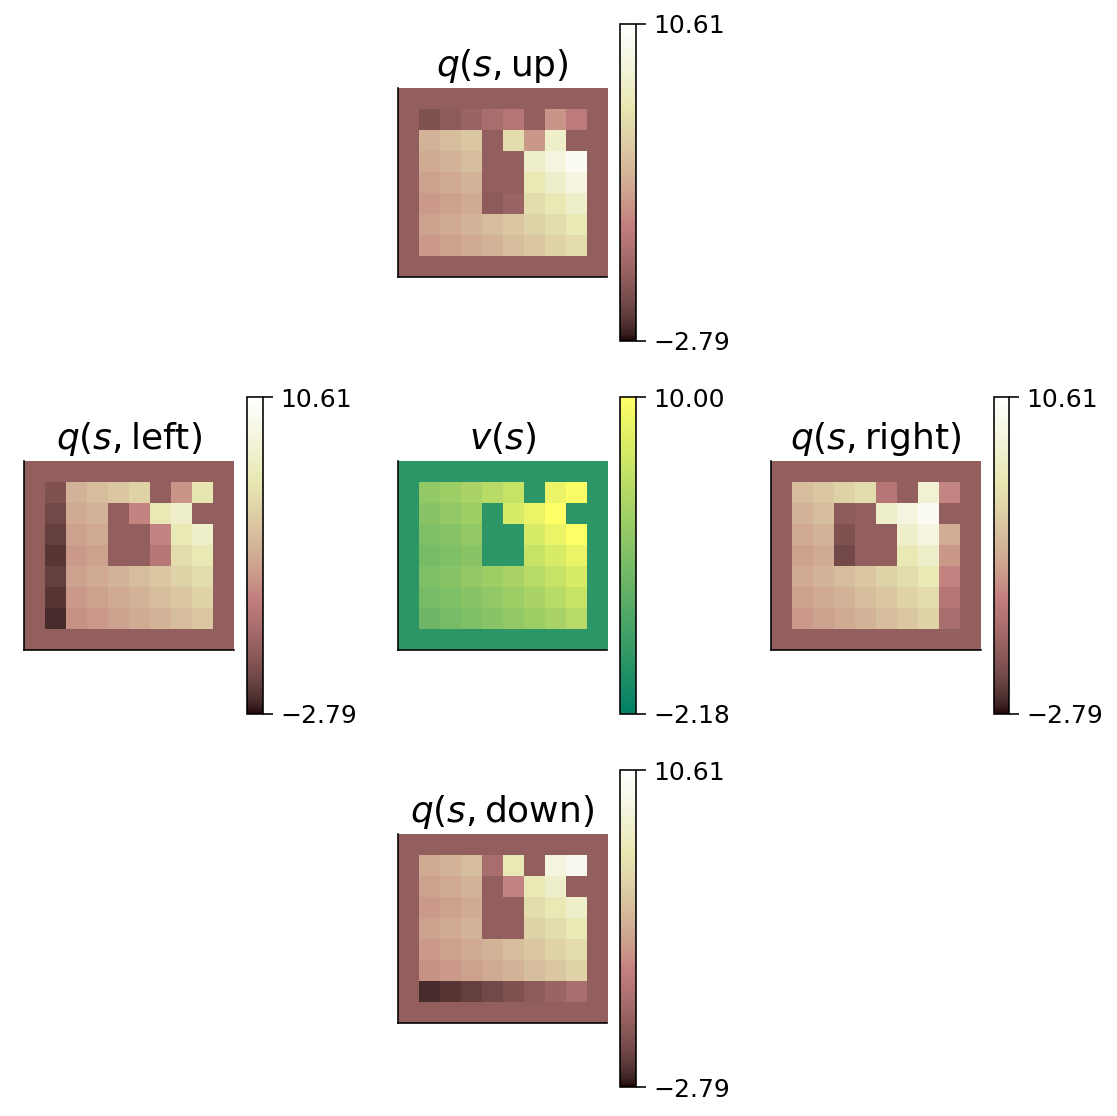

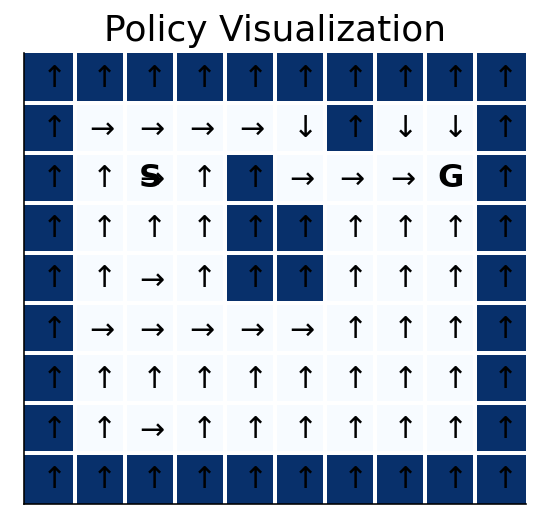

In [36]:
# @title Run your Q-learning
epsilon =   1. # @param {type:"number"}
num_steps = 1e5  # @param {type:"number"}
num_steps = int(num_steps)

# Environment
grid = build_gridworld_task(task='obstacle')
environment, environment_spec = setup_environment(grid)

# Behavior policy
behavior_policy = lambda qval: epsilon_greedy(qval, epsilon=epsilon)

# Agent
agent = QLearningAgent(environment_spec, behavior_policy, step_size=0.1)

# Run experiment and get the value functions from agent
returns = run_loop(environment=environment, agent=agent, num_steps=num_steps)

# Get the q-values
q = agent.q_values.reshape(grid.layout.shape + (4,))

# Visualize value functions
print('AFTER {:,} STEPS ...'.format(num_steps))
plot_action_values(q, epsilon=0)

# Visualise the greedy policy
grid.plot_greedy_policy(q)
plt.show()

### Experiment with different levels of greediness

* The default was $\epsilon=1.$, what does this correspond to?
* Try also $\epsilon =0.1, 0.5$. What do you observe? Does the behaviour policy affect the training in any way?

AFTER 100,000 STEPS ...


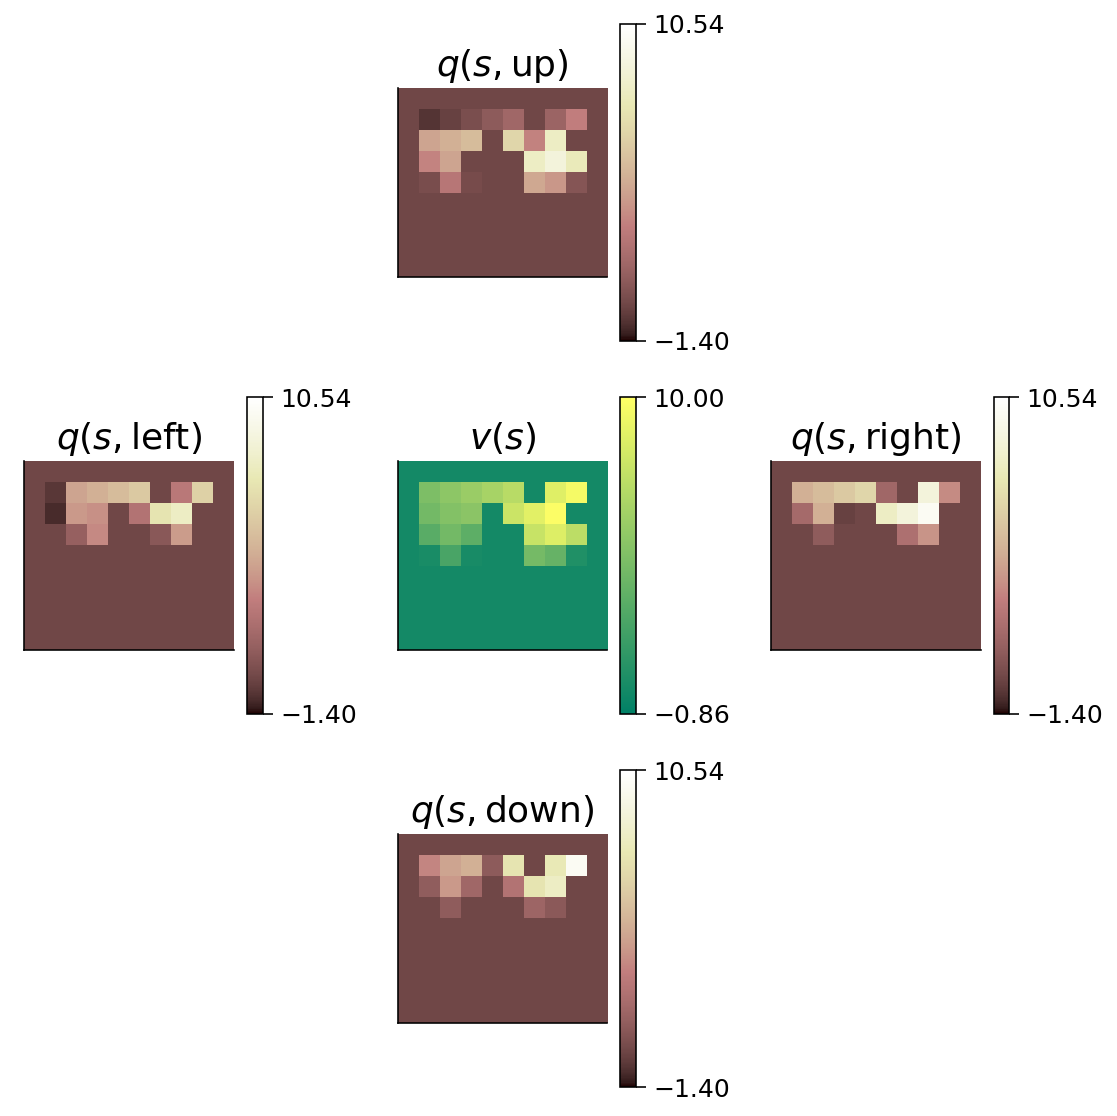

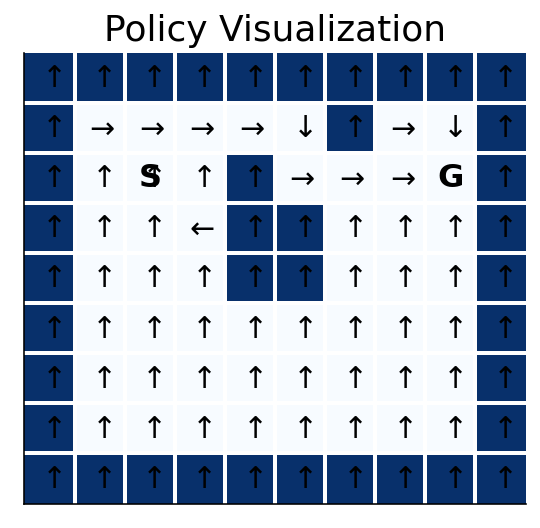

In [37]:
# @title Run the cell
epsilon = 0.1  # @param {type:"number"}
num_steps = 1e5  # @param {type:"number"}
num_steps = int(num_steps)

# Environment
grid = build_gridworld_task(task='obstacle')
environment, environment_spec = setup_environment(grid)

# Behavior policy
behavior_policy = lambda qval: epsilon_greedy(qval, epsilon=epsilon)

# Agent
agent = QLearningAgent(environment_spec, behavior_policy, step_size=0.1)

# Run experiment and get the value functions from agent
returns = run_loop(environment=environment, agent=agent, num_steps=num_steps)

# Get the q-values
q = agent.q_values.reshape(grid.layout.shape + (4,))

# Visualize value functions
print('AFTER {:,} STEPS ...'.format(num_steps))
plot_action_values(q, epsilon=epsilon)

# Visualise the greedy policy
grid.plot_greedy_policy(q)
plt.show()

---
# Section 6: Function Approximation

*Time estimate: ~25mins*

In [38]:
# @title Video 6: Function approximation
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1sg411M7cn", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"7_MYePyYhrM", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 6: Function approximation')

display(out)

<center><img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W3D2_BasicReinforcementLearning/static/fm_RL_loop.png" width="500" /></center>

So far we only considered look-up tables for value-functions. In all previous cases every state and action pair $(\color{red}{s}, \color{blue}{a})$, had an entry in our $\color{green}Q$-table. Again, this is possible in this environment as the number of states is equal to the number of cells in the grid. But this is not scalable to situations where, say, the goal location changes or the obstacles are in different locations at every episode (consider how big the table could be in this situation?).

An example (not covered in this tutorial) is ATARI from pixels, where the number of possible frames an agent can see is exponential in the number of pixels on the screen.

<center><img width="200" alt="portfolio_view" src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W3D2_BasicReinforcementLearning/static/atari_pixels.gif"></center>

But what we **really** want is just to be able to *compute* the Q-value, when fed with a particular $(\color{red}{s}, \color{blue}{a})$ pair. So if we had a way to get a function to do this work instead of keeping a big table, we'd get around this problem.

To address this, we can use **function approximation** as a way to generalize Q-values over some representation of the very large state space, and **train** them to output the values they should. In this section, we will explore $\color{green}Q$-learning with function approximation, which (although it has been theoretically proven to diverge for some degenerate MDPs) can yield impressive results in very large environments. In particular, we will look at [Neural Fitted Q (NFQ) Iteration](http://ml.informatik.uni-freiburg.de/former/_media/publications/rieecml05.pdf) and [Deep Q-Networks (DQN)](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf).



## Section 6.1 Replay Buffers
An important property of off-policy methods like $\color{green}Q$-learning is that they involve two policies: one for exploration and one that is being optimized (via the $\color{green}Q$-function updates). This means that we can generate data from the **behavior** policy and insert that data into some form of data storage---usually referred to as **replay**.

In order to optimize the $\color{green}Q$-function we can then sample data from the replay <font color='purple'>**dataset**</font> and use that data to perform an update. An illustration of this learning loop is shown below.

<center><img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W3D2_BasicReinforcementLearning/static/agent_loop.png" width="400" /></center> 

In the next cell we will show how to implement a simple replay buffer. This can be as simple as a python list containing transition data. In more complicated scenarios we might want to have a more performance-tuned variant, we might have to be more concerned about how large replay is and what to do when its full, and we might want to sample from replay in different ways. But a simple python list can go a surprisingly long way.

In [39]:
# Simple replay buffer

# Create a convenient container for the SARSA tuples required by deep RL agents.
Transitions = collections.namedtuple(
    'Transitions', ['state', 'action', 'reward', 'discount', 'next_state'])

class ReplayBuffer(object):
  """
  A simple Python Replay Buffer.
  Queue based implementation.
  """

  def __init__(self, capacity: int = None):
    self.buffer = collections.deque(maxlen=capacity)
    self._prev_state = None

  def add_first(self, initial_timestep: dm_env.TimeStep):
    self._prev_state = initial_timestep.observation

  def add(self, action: int, timestep: dm_env.TimeStep):
    transition = Transitions(
        state=self._prev_state,
        action=action,
        reward=timestep.reward,
        discount=timestep.discount,
        next_state=timestep.observation,
    )
    self.buffer.append(transition)
    self._prev_state = timestep.observation

  def sample(self, batch_size: int) -> Transitions:
    # Sample a random batch of Transitions as a list.
    batch_as_list = random.sample(self.buffer, batch_size)

    # Convert the list of `batch_size` Transitions into a single Transitions
    # object where each field has `batch_size` stacked fields.
    return tree_utils.stack_sequence_fields(batch_as_list)

  def flush(self) -> Transitions:
    entire_buffer = tree_utils.stack_sequence_fields(self.buffer)
    self.buffer.clear()
    return entire_buffer

  def is_ready(self, batch_size: int) -> bool:
    return batch_size <= len(self.buffer)

## Section 6.2: NFQ Agent
[Neural Fitted Q Iteration](http://ml.informatik.uni-freiburg.de/former/_media/publications/rieecml05.pdf) was one of the first papers to demonstrate how to leverage recent advances in Deep Learning to approximate the Q-value by a neural network.$^1$
In other words, the value $\color{green}Q(\color{red}{s}, \color{blue}{a})$ are approximated by the output of a neural network $\color{green}{Q_w}(\color{red}{s}, \color{blue}{a})$ for each possible action $\color{blue}{a} \in \color{blue}{\mathcal{A}}$.$^2$

When introducing function approximations, and neural networks in particular, we need to have a loss to optimize. But looking back at the tabular setting above, you can see that we already have some notion of error: the **TD error**.

By training our neural network to output values such that the *TD error is minimized*, we will also satisfy the Bellman Optimality Equation, which is a good sufficient condition to enforce, to obtain an optimal policy.
Thanks to automatic differentiation, we can just write the TD error as a loss, e.g., with an $\ell^2$ loss, but others would work too:

\begin{equation}
L(\color{green}w) = \mathbb{E}\left[ \left( \color{green}{r} + \gamma \max_\color{blue}{a'} \color{green}{Q_w}(\color{red}{s'}, \color{blue}{a'}) − \color{green}{Q_w}(\color{red}{s}, \color{blue}{a})  \right)^2\right].
\end{equation}

Then we can compute the gradient with respect to the parameters of the neural network and improve our Q-value approximation incrementally.

NFQ builds on $\color{green}Q$-learning, but if one were to update the Q-values online directly, the training can be unstable and very slow.
Instead, NFQ uses a replay buffer, similar to what we see implemented above (Section 6.1), to update the Q-value in a batched setting.

When it was introduced, it also was entirely off-policy using a uniformly random policy to collect data, which was prone to instability when applied to more complex environments (e.g. when the input are pixels or the tasks are longer and more complicated).
But it is a good stepping stone to the more complex agents used today. Here, we will look at a slightly different and modernised implementation of NFQ.

Below you will find an incomplete NFQ agent that takes in observations from a gridworld. Instead of receiving a tabular state, it receives an observation in the form of its (x,y) coordinates in the gridworld, and the (x,y) coordinates of the goal.
<br />

The goal of this coding exercise is to complete this agent by implementing the loss, using mean squared error.

---

<sub>$^1$ If you read the NFQ paper, they use a "control" notation, where there is a "cost to minimize", instead of "rewards to maximize", so don't be surprised if signs/max/min do not correspond.</sub>

<sub>$^2$ We could feed it $\color{blue}{a}$ as well and ask $Q_w$ for a single scalar value, but given we have a fixed number of actions and we usually need to take an $argmax$ over them, it's easiest to just output them all in one pass.</sub>


### Coding Exercise 6.1: Implement NFQ 

In [40]:
# Create a convenient container for the SARS tuples required by NFQ.
Transitions = collections.namedtuple(
    'Transitions', ['state', 'action', 'reward', 'discount', 'next_state'])


class NeuralFittedQAgent(acme.Actor):
  """
  Implementation of a Neural Fitted Agent
  """

  def __init__(self,
               environment_spec: specs.EnvironmentSpec,
               q_network: nn.Module,
               replay_capacity: int = 100_000,
               epsilon: float = 0.1,
               batch_size: int = 1,
               learning_rate: float = 3e-4):
    """
    Neural Fitted Agent Initialisation

    Args: 
      environment_spec: specs.EnvironmentSpec
        * actions: DiscreteArray(shape=(), dtype=int32, name=action, minimum=0, maximum=3, num_values=4) 
        * observations: Array(shape=(9, 10, 3), dtype=dtype('float32'), name='observation_grid') 
        * rewards: Array(shape=(), dtype=dtype('float32'), name='reward') 
        * discounts: BoundedArray(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0) 
      q_network: nn.Module,
        Q Network
      replay_capacity: int,
        Capacity of the replay buffer [default: 100000]
      epsilon: float
        Controls the exploration-exploitation tradeoff
      batch_size: int 
        Batch Size [default = 1]
      learning_rate: float 
        Rate at which the neural fitted agent learns [default = 3e-4]

    Returns: 
      Nothing
    """
    # Store agent hyperparameters and network.
    self._num_actions = environment_spec.actions.num_values
    self._epsilon = epsilon
    self._batch_size = batch_size
    self._q_network = q_network

    # Container for the computed loss (see run_loop implementation above).
    self.last_loss = 0.0

    # Create the replay buffer.
    self._replay_buffer = ReplayBuffer(replay_capacity)

    # Setup optimizer that will train the network to minimize the loss.
    self._optimizer = torch.optim.Adam(self._q_network.parameters(),lr = learning_rate)
    self._loss_fn = nn.MSELoss()

  def select_action(self, observation):
    """
    Chooses epsilon-greedy action

    Args: 
      observation: enum
        * ObservationType.STATE_INDEX: int32 index of agent occupied tile.
        * ObservationType.AGENT_ONEHOT: NxN float32 grid, with a 1 where the
          agent is and 0 elsewhere.
        * ObservationType.GRID: NxNx3 float32 grid of feature channels.
          First channel contains walls (1 if wall, 0 otherwise), second the
          agent position (1 if agent, 0 otherwise) and third goal position
          (1 if goal, 0 otherwise)
        * ObservationType.AGENT_GOAL_POS: float32 tuple with
          (agent_y, agent_x, goal_y, goal_x) 


    Returns: 
      action: Integer
        Chosen action based on epsilon-greedy policy
    """
    # Compute Q-values.
    q_values = self._q_network(torch.tensor(observation).unsqueeze(0))  # Adds batch dimension.
    q_values = q_values.squeeze(0)   # Removes batch dimension

    # Select epsilon-greedy action.
    if self._epsilon < torch.rand(1):
      action = q_values.argmax(axis=-1)
    else:
      action = torch.randint(low=0, high=self._num_actions , size=(1,), dtype=torch.int64)
    return action

  def q_values(self, observation):
    q_values = self._q_network(torch.tensor(observation).unsqueeze(0))
    return q_values.squeeze(0).detach()

  def update(self):
    """
    Updates replay buffer

    Args: 
      None

    Returns: 
      Nothing
    """
    if not self._replay_buffer.is_ready(self._batch_size):
      # If the replay buffer is not ready to sample from, do nothing.
      return

    # Sample a minibatch of transitions from experience replay.
    transitions = self._replay_buffer.sample(self._batch_size)

    # Note: each of these tensors will be of shape [batch_size, ...].
    s = torch.tensor(transitions.state)
    a = torch.tensor(transitions.action,dtype=torch.int64)
    r = torch.tensor(transitions.reward)
    d = torch.tensor(transitions.discount)
    next_s = torch.tensor(transitions.next_state)

    # Compute the Q-values at next states in the transitions.
    with torch.no_grad():
      q_next_s = self._q_network(next_s)  # Shape [batch_size, num_actions].
      max_q_next_s = q_next_s.max(axis=-1)[0]
      # Compute the TD error and then the losses.
      target_q_value = r + d * max_q_next_s

    # Compute the Q-values at original state.
    q_s = self._q_network(s)

    # Gather the Q-value corresponding to each action in the batch.
    q_s_a = q_s.gather(1, a.view(-1,1)).squeeze(0)
    #################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your implementation
    raise NotImplementedError("Student exercise: complete the NFQ Agent")
    #################################################
    # TODO Average the squared TD errors over the entire batch using
    # self._loss_fn, which is defined above as nn.MSELoss()
    # HINT: Take a look at the reference for nn.MSELoss here:
    #  https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html
    #  What should you put for the input and the target?
    loss = ...

    # Compute the gradients of the loss with respect to the q_network variables.
    self._optimizer.zero_grad()

    loss.backward()
    # Apply the gradient update.
    self._optimizer.step()

    # Store the loss for logging purposes (see run_loop implementation above).
    self.last_loss = loss.detach().numpy()

  def observe_first(self, timestep: dm_env.TimeStep):
    self._replay_buffer.add_first(timestep)

  def observe(self, action: int, next_timestep: dm_env.TimeStep):
    self._replay_buffer.add(action, next_timestep)


# Add event to airtable
atform.add_event('Coding Exercise 6.1: Implement NFQ')

In [41]:
# to_remove solution
# Create a convenient container for the SARS tuples required by NFQ.
Transitions = collections.namedtuple(
    'Transitions', ['state', 'action', 'reward', 'discount', 'next_state'])


class NeuralFittedQAgent(acme.Actor):
  """
  Implementation of a Neural Fitted Agent
  """

  def __init__(self,
               environment_spec: specs.EnvironmentSpec,
               q_network: nn.Module,
               replay_capacity: int = 100_000,
               epsilon: float = 0.1,
               batch_size: int = 1,
               learning_rate: float = 3e-4):
    """
    Neural Fitted Agent Initialisation

    Args: 
      environment_spec: specs.EnvironmentSpec
        * actions: DiscreteArray(shape=(), dtype=int32, name=action, minimum=0, maximum=3, num_values=4) 
        * observations: Array(shape=(9, 10, 3), dtype=dtype('float32'), name='observation_grid') 
        * rewards: Array(shape=(), dtype=dtype('float32'), name='reward') 
        * discounts: BoundedArray(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0) 
      q_network: nn.Module,
        Q Network
      replay_capacity: int,
        Capacity of the replay buffer [default: 100000]
      epsilon: float
        Controls the exploration-exploitation tradeoff
      batch_size: int 
        Batch Size [default = 1]
      learning_rate: float 
        Rate at which the neural fitted agent learns [default = 3e-4]

    Returns: 
      Nothing
    """
    # Store agent hyperparameters and network.
    self._num_actions = environment_spec.actions.num_values
    self._epsilon = epsilon
    self._batch_size = batch_size
    self._q_network = q_network

    # Container for the computed loss (see run_loop implementation above).
    self.last_loss = 0.0

    # Create the replay buffer.
    self._replay_buffer = ReplayBuffer(replay_capacity)

    # Setup optimizer that will train the network to minimize the loss.
    self._optimizer = torch.optim.Adam(self._q_network.parameters(),lr = learning_rate)
    self._loss_fn = nn.MSELoss()

  def select_action(self, observation):
    """
    Chooses epsilon-greedy action

    Args: 
      observation: enum
        * ObservationType.STATE_INDEX: int32 index of agent occupied tile.
        * ObservationType.AGENT_ONEHOT: NxN float32 grid, with a 1 where the
          agent is and 0 elsewhere.
        * ObservationType.GRID: NxNx3 float32 grid of feature channels.
          First channel contains walls (1 if wall, 0 otherwise), second the
          agent position (1 if agent, 0 otherwise) and third goal position
          (1 if goal, 0 otherwise)
        * ObservationType.AGENT_GOAL_POS: float32 tuple with
          (agent_y, agent_x, goal_y, goal_x) 


    Returns: 
      action: Integer
        Chosen action based on epsilon-greedy policy
    """
    # Compute Q-values.
    q_values = self._q_network(torch.tensor(observation).unsqueeze(0))  # Adds batch dimension.
    q_values = q_values.squeeze(0)   # Removes batch dimension

    # Select epsilon-greedy action.
    if self._epsilon < torch.rand(1):
      action = q_values.argmax(axis=-1)
    else:
      action = torch.randint(low=0, high=self._num_actions , size=(1,), dtype=torch.int64)
    return action

  def q_values(self, observation):
    q_values = self._q_network(torch.tensor(observation).unsqueeze(0))
    return q_values.squeeze(0).detach()

  def update(self):
    """
    Updates replay buffer

    Args: 
      None

    Returns: 
      Nothing
    """
    if not self._replay_buffer.is_ready(self._batch_size):
      # If the replay buffer is not ready to sample from, do nothing.
      return

    # Sample a minibatch of transitions from experience replay.
    transitions = self._replay_buffer.sample(self._batch_size)

    # Note: each of these tensors will be of shape [batch_size, ...].
    s = torch.tensor(transitions.state)
    a = torch.tensor(transitions.action,dtype=torch.int64)
    r = torch.tensor(transitions.reward)
    d = torch.tensor(transitions.discount)
    next_s = torch.tensor(transitions.next_state)

    # Compute the Q-values at next states in the transitions.
    with torch.no_grad():
      q_next_s = self._q_network(next_s)  # Shape [batch_size, num_actions].
      max_q_next_s = q_next_s.max(axis=-1)[0]
      # Compute the TD error and then the losses.
      target_q_value = r + d * max_q_next_s

    # Compute the Q-values at original state.
    q_s = self._q_network(s)

    # Gather the Q-value corresponding to each action in the batch.
    q_s_a = q_s.gather(1, a.view(-1,1)).squeeze(0)
    # TODO Average the squared TD errors over the entire batch using
    # self._loss_fn, which is defined above as nn.MSELoss()
    # HINT: Take a look at the reference for nn.MSELoss here:
    #  https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html
    #  What should you put for the input and the target?
    loss = self._loss_fn(target_q_value, q_s_a)

    # Compute the gradients of the loss with respect to the q_network variables.
    self._optimizer.zero_grad()

    loss.backward()
    # Apply the gradient update.
    self._optimizer.step()

    # Store the loss for logging purposes (see run_loop implementation above).
    self.last_loss = loss.detach().numpy()

  def observe_first(self, timestep: dm_env.TimeStep):
    self._replay_buffer.add_first(timestep)

  def observe(self, action: int, next_timestep: dm_env.TimeStep):
    self._replay_buffer.add(action, next_timestep)


# Add event to airtable
atform.add_event('Coding Exercise 6.1: Implement NFQ')

### Train and Evaluate the NFQ Agent


In [42]:
# @title Training the NFQ Agent
epsilon = 0.4 # @param {type:"number"}

max_episode_length = 200

# Create the environment.
grid = build_gridworld_task(
    task='simple',
    observation_type=ObservationType.AGENT_GOAL_POS,
    max_episode_length=max_episode_length)
environment, environment_spec = setup_environment(grid)

# Define the neural function approximator (aka Q network).
q_network = nn.Sequential(nn.Linear(4, 50),
                          nn.ReLU(),
                          nn.Linear(50, 50),
                          nn.ReLU(),
                          nn.Linear(50, environment_spec.actions.num_values))

# Build the trainable Q-learning agent
agent = NeuralFittedQAgent(
    environment_spec,
    q_network,
    epsilon=epsilon,
    replay_capacity=100_000,
    batch_size=10,
    learning_rate=1e-3)

returns = run_loop(
    environment=environment,
    agent=agent,
    num_episodes=500,
    logger_time_delta=1.,
    log_loss=True)

In [43]:
# @title Evaluating the agent (set $\epsilon=0$)
# @markdown ##### Temporarily change epsilon to be more greedy; remember to change it back.

agent._epsilon = 0.0

# Record a few episodes.
frames = evaluate(environment, agent, evaluation_episodes=5)

# Change epsilon back.
agent._epsilon = epsilon

# Display the video of the episodes.
display_video(frames, frame_rate=6)

Episode 0 ended with reward 10.0 in 5 steps
Episode 1 ended with reward 10.0 in 5 steps
Episode 2 ended with reward 10.0 in 5 steps
Episode 3 ended with reward 10.0 in 5 steps
Episode 4 ended with reward 10.0 in 5 steps


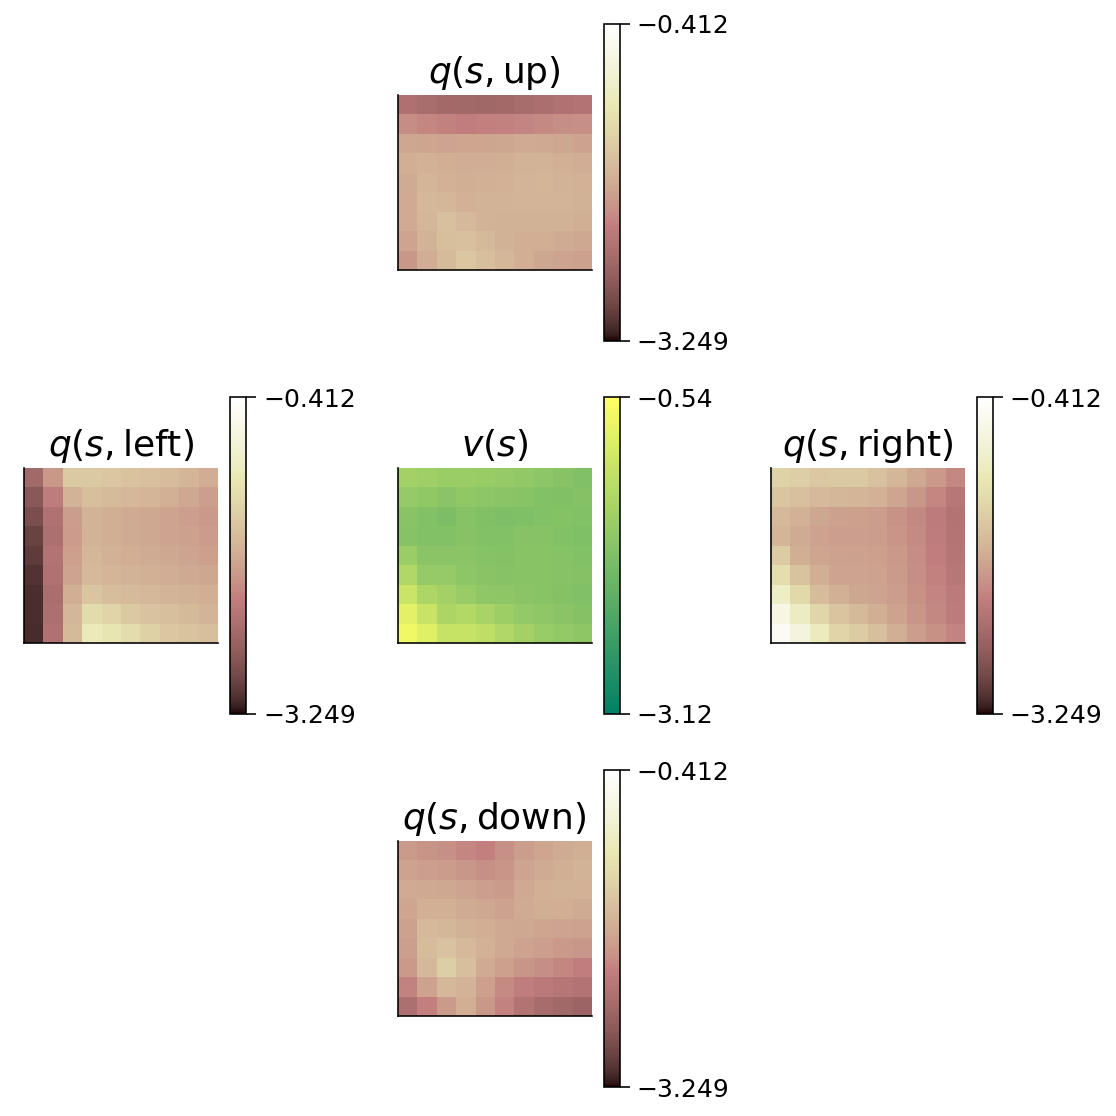

In [44]:
# @title Visualise the learned $Q$ values

# @markdown ##### Evaluate the policy for every state, similar to tabular agents above.

environment.reset()
pi = np.zeros(grid._layout_dims, dtype=np.int32)
q = np.zeros(grid._layout_dims + (4, ))
for y in range(grid._layout_dims[0]):
  for x in range(grid._layout_dims[1]):
    # Hack observation to see what the Q-network would output at that point.
    environment.set_state(x, y)
    obs = environment.get_obs()
    q[y, x] = np.asarray(agent.q_values(obs))
    pi[y, x] = np.asarray(agent.select_action(obs))

plot_action_values(q)

Compare the Q-values approximated with the neural network with the tabular case in **Section 5.3**. Notice how the neural network is generalizing from the visited states to the unvisited similar states, while in the tabular case we updated the value of each state only when we visited that state.

### Compare the greedy and behaviour ($\epsilon$-greedy) policies

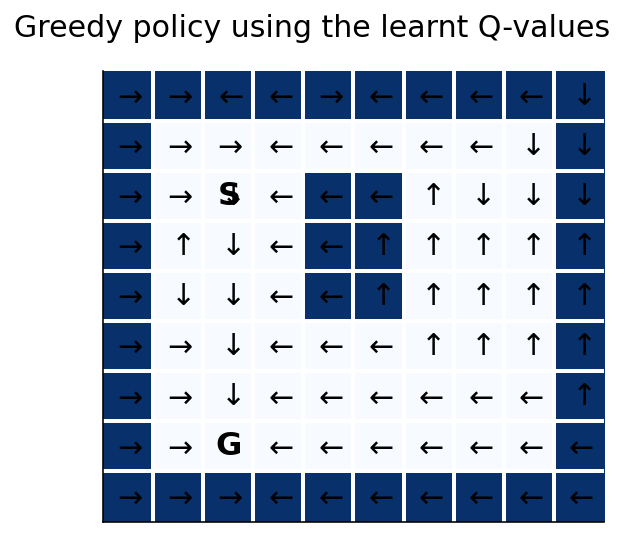

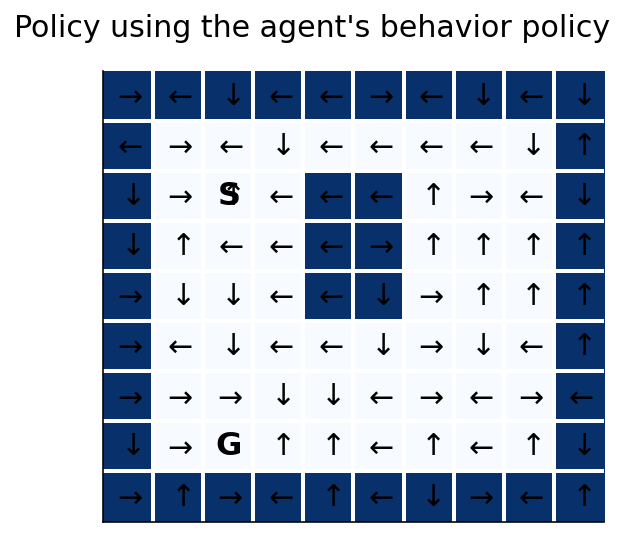

In [45]:
# @title Compare the greedy policy with the agent's policy

# @markdown ##### Notice that the agent's behavior policy has a lot more randomness, due to the high $\epsilon$. However, the greedy policy that's learned is optimal.

environment.plot_greedy_policy(q)
plt.figtext(-.08, .95, 'Greedy policy using the learnt Q-values')
plt.title('')
plt.show()

environment.plot_policy(pi)
plt.figtext(-.08, .95, "Policy using the agent's behavior policy")
plt.title('')
plt.show()

---
# Section 7: RL in the real world

*Time estimate: ~10mins*

In [46]:
# @title Video 7: Real-world applications and ethics
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1Nq4y1X7AF", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"5kBtiW88QVw", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 7: Real-world applications and ethics')

display(out)

## Exercise 7: Group discussion

Form a group of 2-3 and have discussions (roughly 3 minutes each) of the following questions:

1. **Safety**: what are some safety issues that arise in RL that don’t arise with say, supervised learning?

2. **Generalization**: What happens if your RL agent is presented with data it hasn’t trained on? (“goes out of distribution”)

3. How important do you think **interpretability** is in the ethical and safe deployment of RL agents in the real world? 

This should be a very open-ended discussion. Try to have everyone say at least
one thing. They can either take these 3 questions in turn, with 3-4 minutes
allotted to each, or address them all at once, and allow for a more natural
conversation.


In [47]:
# to_remove explanation
"""
Encourage students to consider different examples of RL in the real
world that have safety issues that don't necessarily come up with supervised
learning, due to the fact that in RL, agents must *interact* with the world,
and explore.

Self-driving cars is a really salient example, but also consider using RL in
the health-care setting, where exploration would be unethical. What can be done
in this case? (Consider offline RL, using simulations, safeguards, etc.)

Interpretability can help with the safe deployment of deep RL algorithms
because we can have higher expectation that our agents will not perform
unpredictable actions, or if they do, we can at least understand why they did,
and work to prevent such occurrences in the future.
""";

---
# Summary

*Time estimate: ~3mins*

In this tutorial, we learn the most important aspects of RL. Within the RL framework, we are able to identify the different components: Environment, Agent, States, and Actions. In addition, we learned and understand the Bellman Equation and components involved. We implemented tabular value-based model-free learning (Q-learning and SARSA). Finally, we discussed real-world applications and ethical issues of RL.

If you have time left, in Bonus sections you can run a DQN agent and experiment with different hyperparameters (Bonus 1), and you can have a high-level understanding of other (non value-based) RL methods (Bonus 2).

See also our *Appendix and further reading* for more information.

In [48]:
# @title Video 8: How to learn more
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1WM4y1T7G5", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"dKaOpgor5Ek", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 8: How to learn more')

display(out)

In [49]:
# @title Airtable Submission Link
from IPython import display as IPydisplay
IPydisplay.HTML(
   f"""
 <div>
   <a href= "{atform.url()}" target="_blank">
   <img src="https://github.com/NeuromatchAcademy/course-content-dl/blob/main/tutorials/static/SurveyButton.png?raw=1"
 alt="button link end of day Survey" style="width:410px"></a>
   </div>""" )

---
# Bonus 1: DQN

*Time estimate: ~30mins*

In [50]:
# @title Video 9: Deep Q-Networks (DQN)
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1Mo4y1Q7yD", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"HEDoNtV1y-w", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 9: Deep Q-Networks (DQN)')

display(out)

<center><img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W3D2_BasicReinforcementLearning/static/DQN.jpg" width="500" /><figcaption>Adopted from <a href="https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf">Mnih et al., 2015</a></figcaption></center> 


In this section, we will look at an advanced deep RL Agent based on the following publication, [Playing Atari with Deep Reinforcement Learning](https://deepmind.com/research/publications/playing-atari-deep-reinforcement-learning), which introduced the first deep learning model to successfully learn control policies directly from high-dimensional pixel inputs using RL.

Here the agent will act directly on a pixel representation of the gridworld. You can find an incomplete implementation below.



### Bonus Coding Exercise 1: Run a DQN Agent 


In [51]:
class DQN(acme.Actor):
  """
  Implementation of a Deep Q Network Agent
  """

  def __init__(self,
               environment_spec: specs.EnvironmentSpec,
               network: nn.Module,
               replay_capacity: int = 100_000,
               epsilon: float = 0.1,
               batch_size: int = 1,
               learning_rate: float = 5e-4,
               target_update_frequency: int = 10):
    """
    DQN Based Agent Initialisation

    Args: 
      environment_spec: specs.EnvironmentSpec
        * actions: DiscreteArray(shape=(), dtype=int32, name=action, minimum=0, maximum=3, num_values=4) 
        * observations: Array(shape=(9, 10, 3), dtype=dtype('float32'), name='observation_grid') 
        * rewards: Array(shape=(), dtype=dtype('float32'), name='reward') 
        * discounts: BoundedArray(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0) 
      network: nn.Module
        Deep Q Network
      replay_capacity: int
        Capacity of the replay buffer [default: 100000]
      epsilon: float
        Controls the exploration-exploitation tradeoff
      batch_size: int 
        Batch Size [default = 1]
      learning_rate: float 
        Rate at which the neural fitted agent learns [default = 3e-4]
      target_update_frequency: int
        Frequency with which target network is updated

    Returns: 
      Nothing
    """
    # Store agent hyperparameters and network.
    self._num_actions = environment_spec.actions.num_values
    self._epsilon = epsilon
    self._batch_size = batch_size
    self._q_network = q_network

    # Create a second q net with the same structure and initial values, which
    # we'll be updating separately from the learned q-network.
    self._target_network = copy.deepcopy(self._q_network)

    # Container for the computed loss (see run_loop implementation above).
    self.last_loss = 0.0

    # Create the replay buffer.
    self._replay_buffer = ReplayBuffer(replay_capacity)
    # Keep an internal tracker of steps
    self._current_step = 0

    # How often to update the target network
    self._target_update_frequency = target_update_frequency
    # Setup optimizer that will train the network to minimize the loss.
    self._optimizer = torch.optim.Adam(self._q_network.parameters(), lr=learning_rate)
    self._loss_fn = nn.MSELoss()

  def select_action(self, observation):
    """
    Action Selection Algorithm

    Args: 
      observation: enum
        * ObservationType.STATE_INDEX: int32 index of agent occupied tile.
        * ObservationType.AGENT_ONEHOT: NxN float32 grid, with a 1 where the
          agent is and 0 elsewhere.
        * ObservationType.GRID: NxNx3 float32 grid of feature channels.
          First channel contains walls (1 if wall, 0 otherwise), second the
          agent position (1 if agent, 0 otherwise) and third goal position
          (1 if goal, 0 otherwise)
        * ObservationType.AGENT_GOAL_POS: float32 tuple with
          (agent_y, agent_x, goal_y, goal_x) 

    Returns: 
      action: Integer
        Chosen random action 
    """
    # Compute Q-values.
    # Sonnet requires a batch dimension, which we squeeze out right after.
    q_values = self._q_network(torch.tensor(observation).unsqueeze(0))  # Adds batch dimension.
    q_values = q_values.squeeze(0)   # Removes batch dimension

    # Select epsilon-greedy action.
    if self._epsilon < torch.rand(1):
      action = q_values.argmax(axis=-1)
    else:
      action = torch.randint(low=0, high=self._num_actions , size=(1,), dtype=torch.int64)
    return action

  def q_values(self, observation):
    q_values = self._q_network(torch.tensor(observation).unsqueeze(0))
    return q_values.squeeze(0).detach()

  def update(self):
    """
    Updates replay buffer

    Args: 
      None

    Returns: 
      Nothing
    """
    self._current_step += 1

    if not self._replay_buffer.is_ready(self._batch_size):
      # If the replay buffer is not ready to sample from, do nothing.
      return

    # Sample a minibatch of transitions from experience replay.
    transitions = self._replay_buffer.sample(self._batch_size)

    # Optionally unpack the transitions to lighten notation.
    # Note: each of these tensors will be of shape [batch_size, ...].
    s = torch.tensor(transitions.state)
    a = torch.tensor(transitions.action,dtype=torch.int64)
    r = torch.tensor(transitions.reward)
    d = torch.tensor(transitions.discount)
    next_s = torch.tensor(transitions.next_state)

    # Compute the Q-values at next states in the transitions.
    with torch.no_grad():
      #################################################
      # Fill in missing code below (...),
      # then remove or comment the line below to test your implementation
      raise NotImplementedError("Student exercise: complete the DQN Agent")
      #################################################
      #TODO get the value of the next states evaluated by the target network
      #HINT: use self._target_network, defined above.
      q_next_s = ...  # Shape [batch_size, num_actions].
      max_q_next_s = q_next_s.max(axis=-1)[0]
      # Compute the TD error and then the losses.
      target_q_value = r + d * max_q_next_s

    # Compute the Q-values at original state.
    q_s = self._q_network(s)

    # Gather the Q-value corresponding to each action in the batch.
    q_s_a = q_s.gather(1, a.view(-1,1)).squeeze(0)

    # Average the squared TD errors over the entire batch
    loss = self._loss_fn(target_q_value, q_s_a)

    # Compute the gradients of the loss with respect to the q_network variables.
    self._optimizer.zero_grad()

    loss.backward()
    # Apply the gradient update.
    self._optimizer.step()

    if self._current_step % self._target_update_frequency == 0:
      self._target_network.load_state_dict(self._q_network.state_dict())
    # Store the loss for logging purposes (see run_loop implementation above).
    self.last_loss = loss.detach().numpy()

  def observe_first(self, timestep: dm_env.TimeStep):
    self._replay_buffer.add_first(timestep)

  def observe(self, action: int, next_timestep: dm_env.TimeStep):
    self._replay_buffer.add(action, next_timestep)


# Add event to airtable
atform.add_event('Coding Exercise 7.1: Run a DQN Agent')

# Create a convenient container for the SARS tuples required by NFQ.
Transitions = collections.namedtuple(
    'Transitions', ['state', 'action', 'reward', 'discount', 'next_state'])

In [52]:
# to_remove solution
class DQN(acme.Actor):
  """
  Implementation of a Deep Q Network Agent
  """

  def __init__(self,
               environment_spec: specs.EnvironmentSpec,
               network: nn.Module,
               replay_capacity: int = 100_000,
               epsilon: float = 0.1,
               batch_size: int = 1,
               learning_rate: float = 5e-4,
               target_update_frequency: int = 10):
    """
    DQN Based Agent Initialisation

    Args: 
      environment_spec: specs.EnvironmentSpec
        * actions: DiscreteArray(shape=(), dtype=int32, name=action, minimum=0, maximum=3, num_values=4) 
        * observations: Array(shape=(9, 10, 3), dtype=dtype('float32'), name='observation_grid') 
        * rewards: Array(shape=(), dtype=dtype('float32'), name='reward') 
        * discounts: BoundedArray(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0) 
      network: nn.Module
        Deep Q Network
      replay_capacity: int
        Capacity of the replay buffer [default: 100000]
      epsilon: float
        Controls the exploration-exploitation tradeoff
      batch_size: int 
        Batch Size [default = 1]
      learning_rate: float 
        Rate at which the neural fitted agent learns [default = 3e-4]
      target_update_frequency: int
        Frequency with which target network is updated

    Returns: 
      Nothing
    """
    # Store agent hyperparameters and network.
    self._num_actions = environment_spec.actions.num_values
    self._epsilon = epsilon
    self._batch_size = batch_size
    self._q_network = q_network

    # Create a second q net with the same structure and initial values, which
    # we'll be updating separately from the learned q-network.
    self._target_network = copy.deepcopy(self._q_network)

    # Container for the computed loss (see run_loop implementation above).
    self.last_loss = 0.0

    # Create the replay buffer.
    self._replay_buffer = ReplayBuffer(replay_capacity)
    # Keep an internal tracker of steps
    self._current_step = 0

    # How often to update the target network
    self._target_update_frequency = target_update_frequency
    # Setup optimizer that will train the network to minimize the loss.
    self._optimizer = torch.optim.Adam(self._q_network.parameters(), lr=learning_rate)
    self._loss_fn = nn.MSELoss()

  def select_action(self, observation):
    """
    Action Selection Algorithm

    Args: 
      observation: enum
        * ObservationType.STATE_INDEX: int32 index of agent occupied tile.
        * ObservationType.AGENT_ONEHOT: NxN float32 grid, with a 1 where the
          agent is and 0 elsewhere.
        * ObservationType.GRID: NxNx3 float32 grid of feature channels.
          First channel contains walls (1 if wall, 0 otherwise), second the
          agent position (1 if agent, 0 otherwise) and third goal position
          (1 if goal, 0 otherwise)
        * ObservationType.AGENT_GOAL_POS: float32 tuple with
          (agent_y, agent_x, goal_y, goal_x) 

    Returns: 
      action: Integer
        Chosen random action 
    """
    # Compute Q-values.
    # Sonnet requires a batch dimension, which we squeeze out right after.
    q_values = self._q_network(torch.tensor(observation).unsqueeze(0))  # Adds batch dimension.
    q_values = q_values.squeeze(0)   # Removes batch dimension

    # Select epsilon-greedy action.
    if self._epsilon < torch.rand(1):
      action = q_values.argmax(axis=-1)
    else:
      action = torch.randint(low=0, high=self._num_actions , size=(1,), dtype=torch.int64)
    return action

  def q_values(self, observation):
    q_values = self._q_network(torch.tensor(observation).unsqueeze(0))
    return q_values.squeeze(0).detach()

  def update(self):
    """
    Updates replay buffer

    Args: 
      None

    Returns: 
      Nothing
    """
    self._current_step += 1

    if not self._replay_buffer.is_ready(self._batch_size):
      # If the replay buffer is not ready to sample from, do nothing.
      return

    # Sample a minibatch of transitions from experience replay.
    transitions = self._replay_buffer.sample(self._batch_size)

    # Optionally unpack the transitions to lighten notation.
    # Note: each of these tensors will be of shape [batch_size, ...].
    s = torch.tensor(transitions.state)
    a = torch.tensor(transitions.action,dtype=torch.int64)
    r = torch.tensor(transitions.reward)
    d = torch.tensor(transitions.discount)
    next_s = torch.tensor(transitions.next_state)

    # Compute the Q-values at next states in the transitions.
    with torch.no_grad():
      #TODO get the value of the next states evaluated by the target network
      #HINT: use self._target_network, defined above.
      q_next_s = self._target_network(next_s)  # Shape [batch_size, num_actions].
      max_q_next_s = q_next_s.max(axis=-1)[0]
      # Compute the TD error and then the losses.
      target_q_value = r + d * max_q_next_s

    # Compute the Q-values at original state.
    q_s = self._q_network(s)

    # Gather the Q-value corresponding to each action in the batch.
    q_s_a = q_s.gather(1, a.view(-1,1)).squeeze(0)

    # Average the squared TD errors over the entire batch
    loss = self._loss_fn(target_q_value, q_s_a)

    # Compute the gradients of the loss with respect to the q_network variables.
    self._optimizer.zero_grad()

    loss.backward()
    # Apply the gradient update.
    self._optimizer.step()

    if self._current_step % self._target_update_frequency == 0:
      self._target_network.load_state_dict(self._q_network.state_dict())
    # Store the loss for logging purposes (see run_loop implementation above).
    self.last_loss = loss.detach().numpy()

  def observe_first(self, timestep: dm_env.TimeStep):
    self._replay_buffer.add_first(timestep)

  def observe(self, action: int, next_timestep: dm_env.TimeStep):
    self._replay_buffer.add(action, next_timestep)


# Add event to airtable
atform.add_event('Coding Exercise 7.1: Run a DQN Agent')

# Create a convenient container for the SARS tuples required by NFQ.
Transitions = collections.namedtuple(
    'Transitions', ['state', 'action', 'reward', 'discount', 'next_state'])

In [53]:
# @title Train and evaluate the DQN agent

epsilon = 0.25  # @param {type: "number"}
num_episodes = 500  # @param {type: "integer"}
max_episode_length = 50  # @param {type: "integer"}

grid = build_gridworld_task(
    task='simple',
    observation_type=ObservationType.GRID,
    max_episode_length=max_episode_length)
environment, environment_spec = setup_environment(grid)

class Permute(nn.Module):
  """
  Build Agent's Network
  """
  def __init__(self, order: list):
    super(Permute,self).__init__()
    self.order = order

  def forward(self, x):
    return x.permute(self.order)

q_network = nn.Sequential(Permute([0, 3, 1, 2]),
                          nn.Conv2d(3, 32, kernel_size=4,
                                    stride=2,padding=1),
                          nn.ReLU(),
                          nn.Conv2d(32, 64, kernel_size=3,
                                    stride=1, padding=1),
                          nn.ReLU(),
                          nn.MaxPool2d(3, 1),
                          nn.Flatten(),
                          nn.Linear(384, 50),
                          nn.ReLU(),
                          nn.Linear(50, environment_spec.actions.num_values)
                          )

agent = DQN(
    environment_spec=environment_spec,
    network=q_network,
    batch_size=10,
    epsilon=epsilon,
    target_update_frequency=25)

returns = run_loop(
    environment=environment,
    agent=agent,
    num_episodes=num_episodes,
    num_steps=100000)

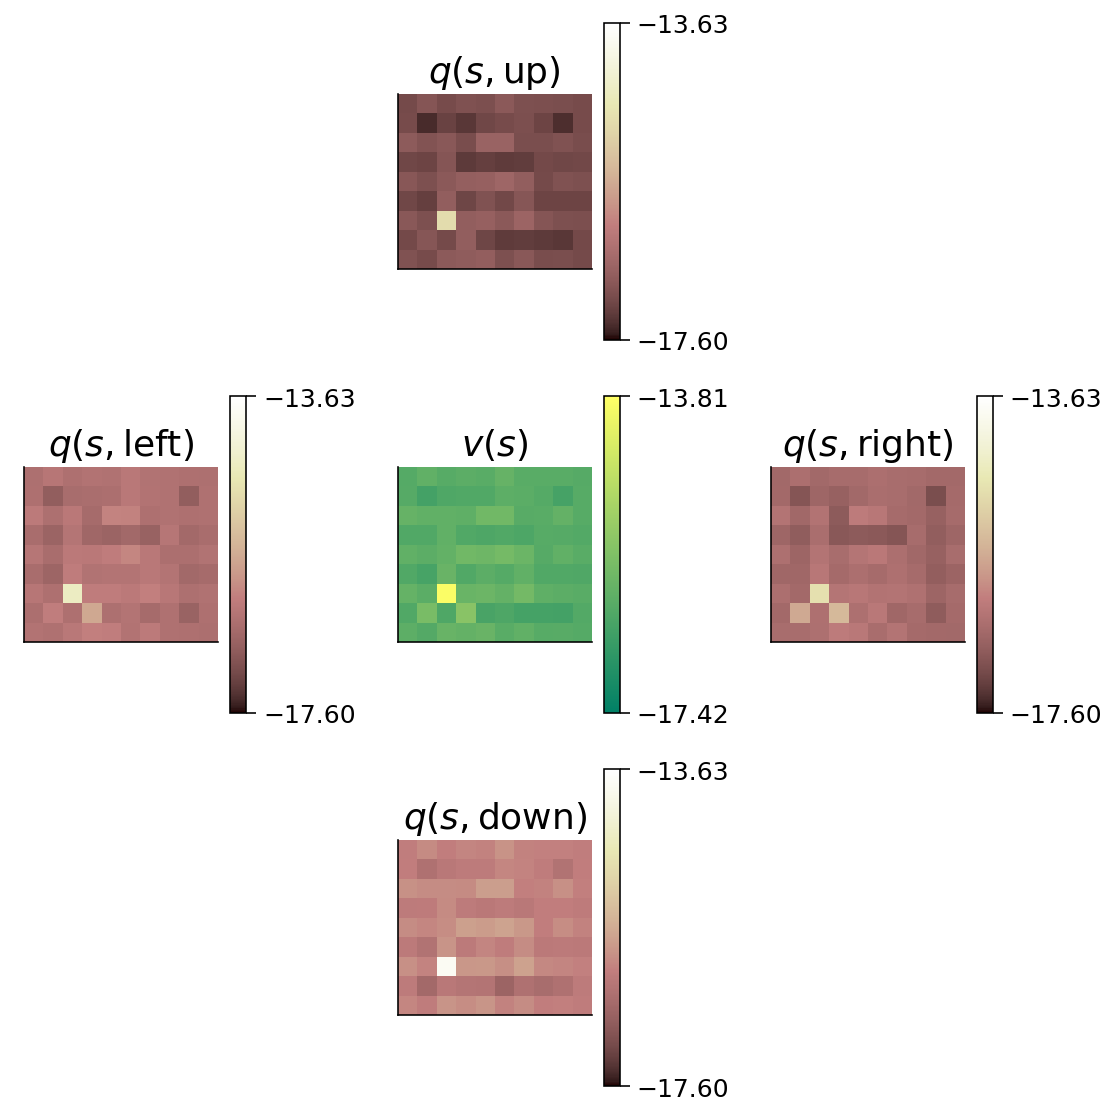

In [54]:
# @title Visualise the learned $Q$ values
# @markdown ##### Evaluate the policy for every state, similar to tabular agents above.

pi = np.zeros(grid._layout_dims, dtype=np.int32)
q = np.zeros(grid._layout_dims + (4,))
for y in range(grid._layout_dims[0]):
  for x in range(grid._layout_dims[1]):
    # Hack observation to see what the Q-network would output at that point.
    environment.set_state(x, y)
    obs = environment.get_obs()
    q[y, x] = np.asarray(agent.q_values(obs))
    pi[y, x] = np.asarray(agent.select_action(obs))

plot_action_values(q)

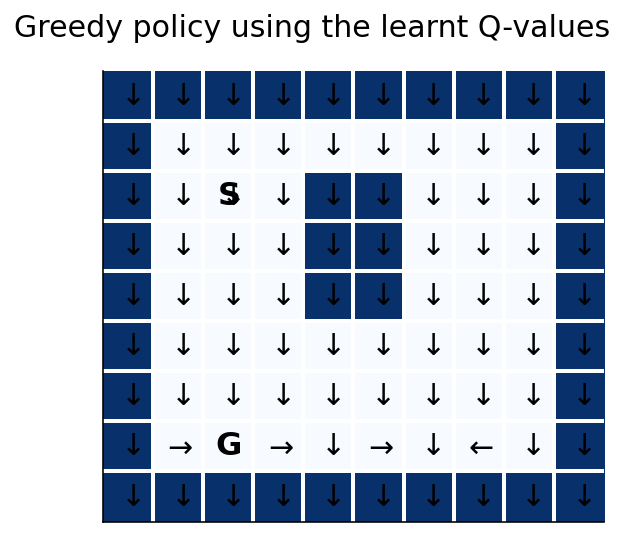

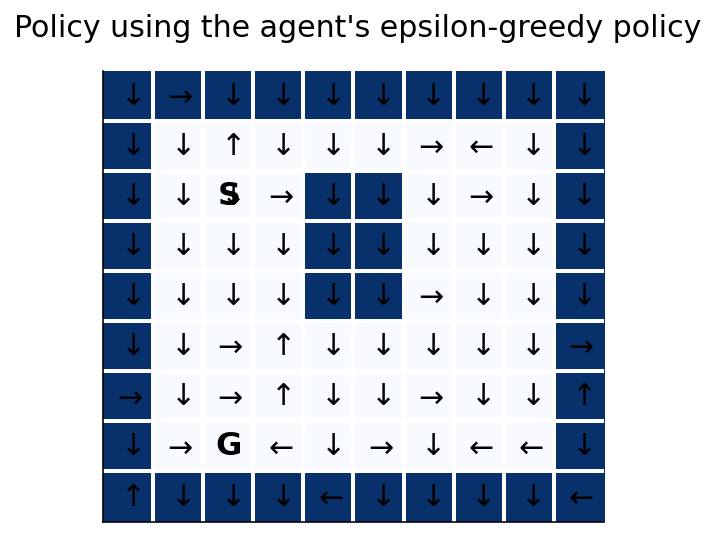

In [55]:
# @title Compare the greedy policy with the agent's policy

environment.plot_greedy_policy(q)
plt.figtext(-.08, .95, "Greedy policy using the learnt Q-values")
plt.title('')
plt.show()

environment.plot_policy(pi)
plt.figtext(-.08, .95, "Policy using the agent's epsilon-greedy policy")
plt.title('')
plt.show()

**Note:** You’ll get a better estimate of the value functions if you increase `num_episodes` and `max_episode_length`, but this will take longer to train. Feel free to play around after the day!

---
# Bonus 2: Beyond Value Based Model-Free Methods

*Time estimate: ~25mins*

In [56]:
# @title Video 10: Other RL Methods
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV14w411977Y", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"1N4Jm9loJx4", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 10: Other RL Methods')

display(out)

## Cartpole task

Here we switch to training on a different kind of task, which has a continuous action space: Cartpole in [Gym](https://gym.openai.com/). As you recall from the video, policy-based methods are particularly well-suited for these kinds of tasks. We will be exploring two of those methods below.

<br>

<center><img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W3D2_BasicReinforcementLearning/static/cartpole_task.gif" height="250" /></center>

In [57]:
# @title Make a CartPole environment, `gym.make('CartPole-v1')`
env = gym.make('CartPole-v1')

# Set seeds
env.seed(SEED)
set_seed(SEED)

Random seed 2021 has been set.


## Bonus 2.1: Policy gradient

Now we will turn to policy gradient methods. Rather than defining the policy in terms of a value function, i.e. $\color{blue}\pi(\color{red}s) = \arg\max_{\color{blue}a}\color{green}Q(\color{red}s, \color{blue}a)$, we will directly parameterize the policy and write it as the distribution

\begin{equation}
\color{blue}a_t \sim \color{blue}\pi_{\theta}(\color{blue}a_t|\color{red}s_t).
\end{equation}

Here $\theta$ represent the parameters of the policy. We will update the policy parameters using gradient ascent to **maximize** expected future reward.

One convenient way to represent the conditional distribution above is as a function that takes a state $\color{red}s$ and returns a distribution over actions $\color{blue}a$.

Defined below is an agent which implements the REINFORCE algorithm. 
REINFORCE (Williams 1992) is the simplest model-free general reinforcement learning technique.

The **basic idea** is to use probabilistic action choice. If the reward at the end turns out to be high, we make **all** actions in this sequence **more likely** (otherwise, we do the opposite).

This strategy could reinforce "bad" actions as well, however they will turn out to be part of trajectories with low reward and will likely not get accentuated.

From the lectures, we know that we need to compute

\begin{equation}
\nabla J(\theta) 
= \mathbb{E}
\left[
  \sum_{t=0}^T \color{green} G_t 
  \nabla\log\color{blue}\pi_\theta(\color{red}{s_t})
\right]
\end{equation}

where $\color{green} G_t$ is the sum over future rewards from time $t$, defined as

\begin{equation}
\color{green} G_t 
= \sum_{n=t}^T \gamma^{n-t} 
\color{green} R(\color{red}{s_t}, \color{blue}{a_t}, \color{red}{s_{t+1}}).
\end{equation}

The algorithm below will collect the state, action, and reward data in its buffer until it reaches a full trajectory. It will then update its policy given the above gradient (and the Adam optimizer).

A policy gradient trains an agent without explicitly mapping the value for every state-action pair in an environment by taking small steps and updating the policy based on the reward associated with that step. In this section, we will build a small network that trains using policy gradient using PyTorch.

The agent can receive a reward immediately for an action or it can receive the award at a later time such as the end of the episode. 

The policy function our agent will try to learn is $\pi_\theta(a,s)$, where $\theta$ is the parameter vector, $s$ is a particular state, and $a$ is an action.

Monte-Carlo Policy Gradient approach will be used, which means the agent will run through an entire episode and then update policy based on the rewards obtained.

In [58]:
# @title Set the hyperparameters for Policy Gradient

num_steps = 300

learning_rate = 0.01  # @param {type:"number"}
gamma = 0.99  # @param {type:"number"}
dropout = 0.6 # @param {type:"number"}

# @markdown Only used in Policy Gradient Method:
hidden_neurons = 128  # @param {type:"integer"}

### Bonus Coding Exercise 2.1: Creating a simple neural network

Below you will find some incomplete code. Fill in the missing code to construct the specified neural network.

Let us define a simple feed forward neural network with one hidden layer of 128 neurons and a dropout of 0.6. Let's use Adam as our optimizer and a learning rate of 0.01. Use the hyperparameters already defined rather than using explicit values.

Using dropout will significantly improve the performance of the policy. Do compare your results with and without dropout and experiment with other hyper-parameter values as well.

In [59]:
class PolicyGradientNet(nn.Module):
  """
  Defines Policy Gradient Network with the following attributes: 
    Feed Forward Network with a single hidden layer 
    width: 128 neurons
    dropout: 0.6
    Optimizer: Adam
    Learning Rate: 0.01
  """
  
  def __init__(self):
    """
    Initiate Policy Gradient Network with above mentioned parameters/hyperparameters

    Args: 
      None
    
    Returns: 
      Nothing
    """
    super(PolicyGradientNet, self).__init__()
    self.state_space = env.observation_space.shape[0]
    self.action_space = env.action_space.n
    #################################################
    ## TODO for students: Define two linear layers
    ## from the first expression
    raise NotImplementedError("Student exercise: Create FF neural network.")
    #################################################
    # HINT: you can construct linear layers using nn.Linear(); what are the
    # sizes of the inputs and outputs of each of the layers? Also remember
    # that you need to use hidden_neurons (see hyperparameters section above).
    #   https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
    self.l1 = ...
    self.l2 = ...
    self.gamma = ...
    # Episode policy and past rewards
    self.past_policy = Variable(torch.Tensor())
    self.reward_episode = []
    # Overall reward and past loss
    self.past_reward = []
    self.past_loss = []

  def forward(self, x):
    model = torch.nn.Sequential(
        self.l1,
        nn.Dropout(p=dropout),
        nn.ReLU(),
        self.l2,
        nn.Softmax(dim=-1)
    )
    return model(x)

In [60]:
# to_remove solution
class PolicyGradientNet(nn.Module):
  """
  Defines Policy Gradient Network with the following attributes: 
    Feed Forward Network with a single hidden layer 
    width: 128 neurons
    dropout: 0.6
    Optimizer: Adam
    Learning Rate: 0.01
  """

  def __init__(self):
    """
    Initiate Policy Gradient Network with above mentioned parameters/hyperparameters

    Args: 
      None
    
    Returns: 
      Nothing
    """
    super(PolicyGradientNet, self).__init__()
    self.state_space = env.observation_space.shape[0]
    self.action_space = env.action_space.n
    # HINT: you can construct linear layers using nn.Linear(); what are the
    # sizes of the inputs and outputs of each of the layers? Also remember
    # that you need to use hidden_neurons (see hyperparameters section above).
    #   https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
    self.l1 = nn.Linear(self.state_space, hidden_neurons, bias=False)
    self.l2 = nn.Linear(hidden_neurons, self.action_space, bias=False)
    self.gamma = gamma
    # Episode policy and past rewards
    self.past_policy = Variable(torch.Tensor())
    self.reward_episode = []
    # Overall reward and past loss
    self.past_reward = []
    self.past_loss = []

  def forward(self, x):
    model = torch.nn.Sequential(
        self.l1,
        nn.Dropout(p=dropout),
        nn.ReLU(),
        self.l2,
        nn.Softmax(dim=-1)
    )
    return model(x)

Now let's create an instance of the network we have defined and use Adam as the optimizer using the learning_rate as hyperparameter already defined above.

In [61]:
policy = PolicyGradientNet()
pg_optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

### Select Action

The `select_action()` function chooses an action based on our policy probability distribution using the PyTorch distributions package.  Our policy returns a probability for each possible action in our action space (move left or move right) as an array of length two such as [0.7, 0.3].  We then choose an action based on these probabilities, record our history, and return our action. 

In [62]:
def select_action(state):
  """
  Select an action (0 or 1) by running policy model and choosing based on the probabilities in state;

  Args: 
    state: np.ndarray
      Describes Agent's state

  Returns: 
    action: 
      Returns chosen action based on policy's probability distribution 
  """
  state = torch.from_numpy(state).type(torch.FloatTensor)
  state = policy(Variable(state))
  c = Categorical(state)
  action = c.sample()

  # Add log probability of chosen action
  if policy.past_policy.dim() != 0:
    policy.past_policy = torch.cat([policy.past_policy, c.log_prob(action).reshape(1)])
  else:
    policy.past_policy = (c.log_prob(action).reshape(1))
  return action

### Update policy

This function updates the policy.

#### Reward $G_t$
We update our policy by taking a sample of the action value function $Q^{\pi_\theta} (s_t,a_t)$ by playing through episodes of the game.  $Q^{\pi_\theta} (s_t,a_t)$ is defined as the expected return by taking action $a$ in state $s$ following policy $\pi$.

We know that for every step the simulation continues we receive a reward of 1.  We can use this to calculate the policy gradient at each time step, where $r$ is the reward for a particular state-action pair.  Rather than using the instantaneous reward, $r$, we instead use a long term reward $ v_{t} $ where $v_t$ is the discounted sum of all future rewards for the length of the episode.   $v_{t}$ is then,

\begin{equation}
\color{green} G_t 
= \sum_{n=t}^T \gamma^{n-t} 
\color{green} R(\color{red}{s_t}, \color{blue}{a_t}, \color{red}{s_{t+1}}).
\end{equation}

where $\gamma$ is the discount factor (0.99).  For example, if an episode lasts 5 steps, the reward for each step will be [4.90, 3.94, 2.97, 1.99, 1].
Next we scale our reward vector by substracting the mean from each element and scaling to unit variance by dividing by the standard deviation.  This practice is common for machine learning applications and the same operation as Scikit Learn's __[StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)__.  It also has the effect of compensating for future uncertainty.

#### Update Policy: equation
After each episode we apply Monte-Carlo Policy Gradient to improve our policy according to the equation:

\begin{equation}
\Delta\theta_t = \alpha\nabla_\theta \, \log \pi_\theta (s_t,a_t)G_t
\end{equation}

We will then feed our policy history multiplied by our rewards to our optimizer and update the weights of our neural network using stochastic gradient **ascent**.  This should increase the likelihood of actions that got our agent a larger reward.

The following function ```update_policy``` updates the network weights and therefore the policy.



In [63]:
def update_policy():
  """
  Helper function to update network weights and policy

  Args: 
    None

  Returns: 
    Nothing
  """
  R = 0
  rewards = []

  # Discount future rewards back to the present using gamma
  for r in policy.reward_episode[::-1]:
    R = r + policy.gamma * R
    rewards.insert(0, R)

  # Scale rewards
  rewards = torch.FloatTensor(rewards)
  rewards = (rewards - rewards.mean()) / (rewards.std() +
                                          np.finfo(np.float32).eps)

  # Calculate loss
  pg_loss = (torch.sum(torch.mul(policy.past_policy,
                              Variable(rewards)).mul(-1), -1))
  
  # Update network weights
  # Use zero_grad(), backward() and step() methods of the optimizer instance.
  pg_optimizer.zero_grad()
  pg_loss.backward()
  
  # Update the weights
  for param in policy.parameters():
      param.grad.data.clamp_(-1, 1)
  pg_optimizer.step()

  # Save and intialize episode past counters
  policy.past_loss.append(pg_loss.item())
  policy.past_reward.append(np.sum(policy.reward_episode))
  policy.past_policy = Variable(torch.Tensor())
  policy.reward_episode= []

### Training

This is our main policy training loop. For each step in a training episode, we choose an action, take a step through the environment, and record the resulting new state and reward. We call `update_policy()` at the end of each episode to feed the episode history to our neural network and improve our policy.

In [64]:
def policy_gradient_train(episodes):
  """
  Helper function to train policy gradient network

  Args: 
    episodes: List 
      Log of state per episode

  Returns: 
    Nothing
  """
  running_reward = 10
  for episode in range(episodes):
    state = env.reset()
    done = False

    for time in range(1000):
      action = select_action(state)
      # Step through environment using chosen action
      state, reward, done, _ = env.step(action.item())

      # Save reward
      policy.reward_episode.append(reward)
      if done:
        break

    # Used to determine when the environment is solved.
    running_reward = (running_reward * gamma) + (time * (1 - gamma))

    update_policy()

    if episode % 50 == 0:
      print(f"Episode {episode}\tLast length: {time:5.0f}"
            f"\tAverage length: {running_reward:.2f}")

    if running_reward > env.spec.reward_threshold:
      print(f"Solved! Running reward is now {running_reward} "
            f"and the last episode runs to {time} time steps!")
      break

### Run the model

In [65]:
episodes = 500   # @param {type:"integer"}
policy_gradient_train(episodes)

Episode 0	Last length:    12	Average length: 10.02
Episode 50	Last length:   394	Average length: 40.32
Episode 100	Last length:   289	Average length: 117.11
Episode 150	Last length:   132	Average length: 189.72
Episode 200	Last length:   273	Average length: 242.07
Episode 250	Last length:   233	Average length: 278.92
Episode 300	Last length:   499	Average length: 340.06
Episode 350	Last length:   499	Average length: 367.78
Episode 400	Last length:   306	Average length: 379.29
Episode 450	Last length:   297	Average length: 394.21


### Plot the results

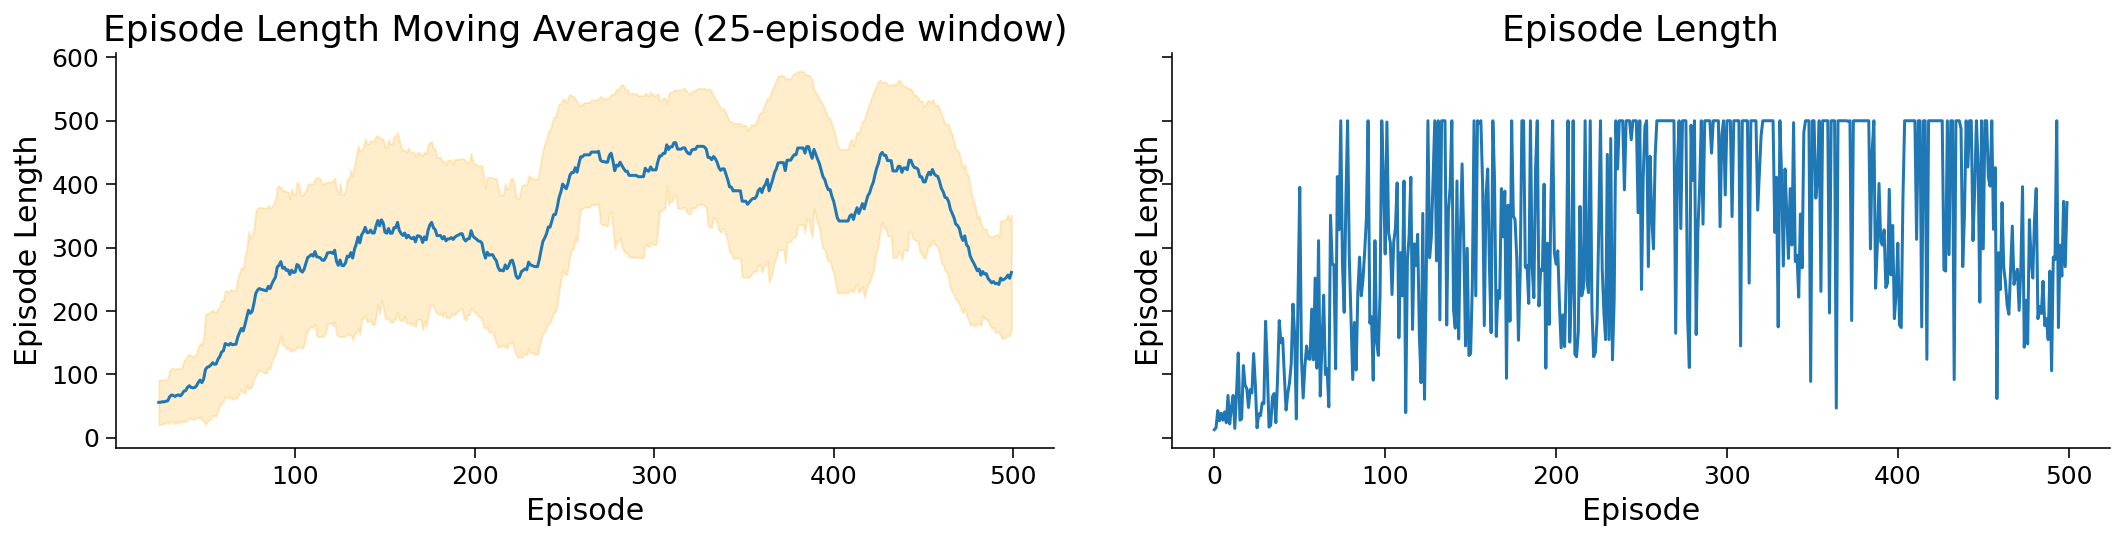

In [66]:
# @title Plot the training performance for policy gradient

def plot_policy_gradient_training():
  """
  Helper function to plot the training performance
  of policy gradient network
  
  Args: 
    None

  Returns: 
    Nothing
  """
  window = int(episodes / 20)

  fig, ((ax1), (ax2)) = plt.subplots(1, 2, sharey=True, figsize=[15, 4]);
  rolling_mean = pd.Series(policy.past_reward).rolling(window).mean()
  std = pd.Series(policy.past_reward).rolling(window).std()
  ax1.plot(rolling_mean)
  ax1.fill_between(range(len(policy.past_reward)),
                   rolling_mean-std, rolling_mean+std,
                   color='orange', alpha=0.2)
  ax1.set_title(f"Episode Length Moving Average ({window}-episode window)")
  ax1.set_xlabel('Episode'); ax1.set_ylabel('Episode Length')

  ax2.plot(policy.past_reward)
  ax2.set_title('Episode Length')
  ax2.set_xlabel('Episode')
  ax2.set_ylabel('Episode Length')

  fig.tight_layout(pad=2)
  plt.show()

plot_policy_gradient_training()

### Bonus Exercise 2.1: Explore different hyperparameters.

Try running the model again, by modifying the hyperparameters and observe the outputs. Be sure to rerun the function definition cells in order to pick up on the updated values.

What do you see when you 

1. increase learning rate
2. decrease learning rate
3. decrease gamma ($\gamma$)
4. increase number of hidden neurons in the network

## Bonus 2.2: Actor-critic

Recall the policy gradient

\begin{equation}
\nabla J(\theta) 
= \mathbb{E}
\left[
  \sum_{t=0}^T \color{green} G_t 
  \nabla\log\color{blue}\pi_\theta(\color{red}{s_t})
\right]
\end{equation}

The policy parameters are updated using Monte Carlo technique and uses random samples. This introduces high variability in log probabilities and cumulative reward values. This leads to noisy gradients and can cause unstable learning.

One way to reduce variance and increase stability is subtracting the cumulative reward by a baseline:

\begin{equation}
\nabla J(\theta) 
= \mathbb{E}
\left[
   \sum_{t=0}^T \color{green} (G_t  - b)
  \nabla\log\color{blue}\pi_\theta(\color{red}{s_t})
\right]
\end{equation}

Intuitively, reducing cumulative reward will make smaller gradients and thus smaller and more stable (hopefully) updates.

From the lecture slides, we know that in Actor Critic Method:
1. The “Critic” estimates the value function. This could be the action-value (the Q value) or state-value (the V value).
2. The “Actor” updates the policy distribution in the direction suggested by the Critic (such as with policy gradients).

Both the Critic and Actor functions are parameterized with neural networks. The "Critic" network parameterizes the Q-value.

In [67]:
# @title Set the hyperparameters for Actor Critic

learning_rate = 0.01  # @param {type:"number"}
gamma = 0.99  # @param {type:"number"}
dropout = 0.6

# Only used in Actor-Critic Method
hidden_size = 256  # @param {type:"integer"}

num_steps = 300

### Actor Critic Network

In [68]:
class ActorCriticNet(nn.Module):
  """
  Build Actor Critic Network
  """

  def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
    """
    Initiate Actor Critic Network 

    Args: 
      num_inputs: int
        Number of inputs incoming into the Network
      num_actions: int
        Number of actions
      hidden_size: int
        Size of hidden layer in the network 
      learning_rate: Float 
        Learning rate of Actor Critic Network

    Returns: 
      Nothing
    """
    super(ActorCriticNet, self).__init__()

    self.num_actions = num_actions
    self.critic_linear1 = nn.Linear(num_inputs, hidden_size)
    self.critic_linear2 = nn.Linear(hidden_size, 1)

    self.actor_linear1 = nn.Linear(num_inputs, hidden_size)
    self.actor_linear2 = nn.Linear(hidden_size, num_actions)

    self.all_rewards = []
    self.all_lengths = []
    self.average_lengths = []

  def forward(self, state):
    """
    Describes forward pass of Actor Critic Network 

    Args: 
      state: np.ndarray
        Describes state

    Returns:
      Value and Policy Distribution
    """
    state = Variable(torch.from_numpy(state).float().unsqueeze(0))
    value = F.relu(self.critic_linear1(state))
    value = self.critic_linear2(value)

    policy_dist = F.relu(self.actor_linear1(state))
    policy_dist = F.softmax(self.actor_linear2(policy_dist), dim=1)

    return value, policy_dist

### Training

In [69]:
def actor_critic_train(episodes):
  """
  Helper function to train Actor Critic Network

  Args: 
    episodes: list 
      Log of episode for all episodes

  Returns:
    Nothing
  """
  all_lengths = []
  average_lengths = []
  all_rewards = []
  entropy_term = 0

  for episode in range(episodes):
    log_probs = []
    values = []
    rewards = []

    state = env.reset()
    for steps in range(num_steps):
      value, policy_dist = actor_critic.forward(state)
      value = value.detach().numpy()[0, 0]
      dist = policy_dist.detach().numpy()

      action = np.random.choice(num_outputs, p=np.squeeze(dist))
      log_prob = torch.log(policy_dist.squeeze(0)[action])
      entropy = -np.sum(np.mean(dist) * np.log(dist))
      new_state, reward, done, _ = env.step(action)

      rewards.append(reward)
      values.append(value)
      log_probs.append(log_prob)
      entropy_term += entropy
      state = new_state

      if done or steps == num_steps - 1:
        qval, _ = actor_critic.forward(new_state)
        qval = qval.detach().numpy()[0, 0]
        all_rewards.append(np.sum(rewards))
        all_lengths.append(steps)
        average_lengths.append(np.mean(all_lengths[-10:]))
        if episode % 50 == 0:
          print(f"episode: {episode},\treward: {np.sum(rewards)},"
                f"\ttotal length: {steps},"
                f"\taverage length: {average_lengths[-1]}")
        break

    # compute Q values
    qvals = np.zeros_like(values)
    for t in reversed(range(len(rewards))):
      qval = rewards[t] + gamma * qval
      qvals[t] = qval

    #update actor critic
    values = torch.FloatTensor(values)
    qvals = torch.FloatTensor(qvals)
    log_probs = torch.stack(log_probs)

    advantage = qvals - values
    actor_loss = (-log_probs * advantage).mean()
    critic_loss = 0.5 * advantage.pow(2).mean()
    ac_loss = actor_loss + critic_loss + 0.001 * entropy_term

    ac_optimizer.zero_grad()
    ac_loss.backward()
    ac_optimizer.step()

  # Store results
  actor_critic.average_lengths = average_lengths
  actor_critic.all_rewards = all_rewards
  actor_critic.all_lengths = all_lengths

### Run the model

In [70]:
episodes = 500   # @param {type:"integer"}

env.reset()

num_inputs = env.observation_space.shape[0]
num_outputs = env.action_space.n

actor_critic = ActorCriticNet(num_inputs, num_outputs, hidden_size)
ac_optimizer = optim.Adam(actor_critic.parameters())

actor_critic_train(episodes)

episode: 0,	reward: 34.0,	total length: 33,	average length: 33.0
episode: 50,	reward: 41.0,	total length: 40,	average length: 34.1
episode: 100,	reward: 17.0,	total length: 16,	average length: 29.1
episode: 150,	reward: 32.0,	total length: 31,	average length: 32.3
episode: 200,	reward: 86.0,	total length: 85,	average length: 65.4
episode: 250,	reward: 17.0,	total length: 16,	average length: 44.2
episode: 300,	reward: 21.0,	total length: 20,	average length: 78.6
episode: 350,	reward: 109.0,	total length: 108,	average length: 89.6
episode: 400,	reward: 176.0,	total length: 175,	average length: 161.0
episode: 450,	reward: 127.0,	total length: 126,	average length: 113.3


### Plot the results

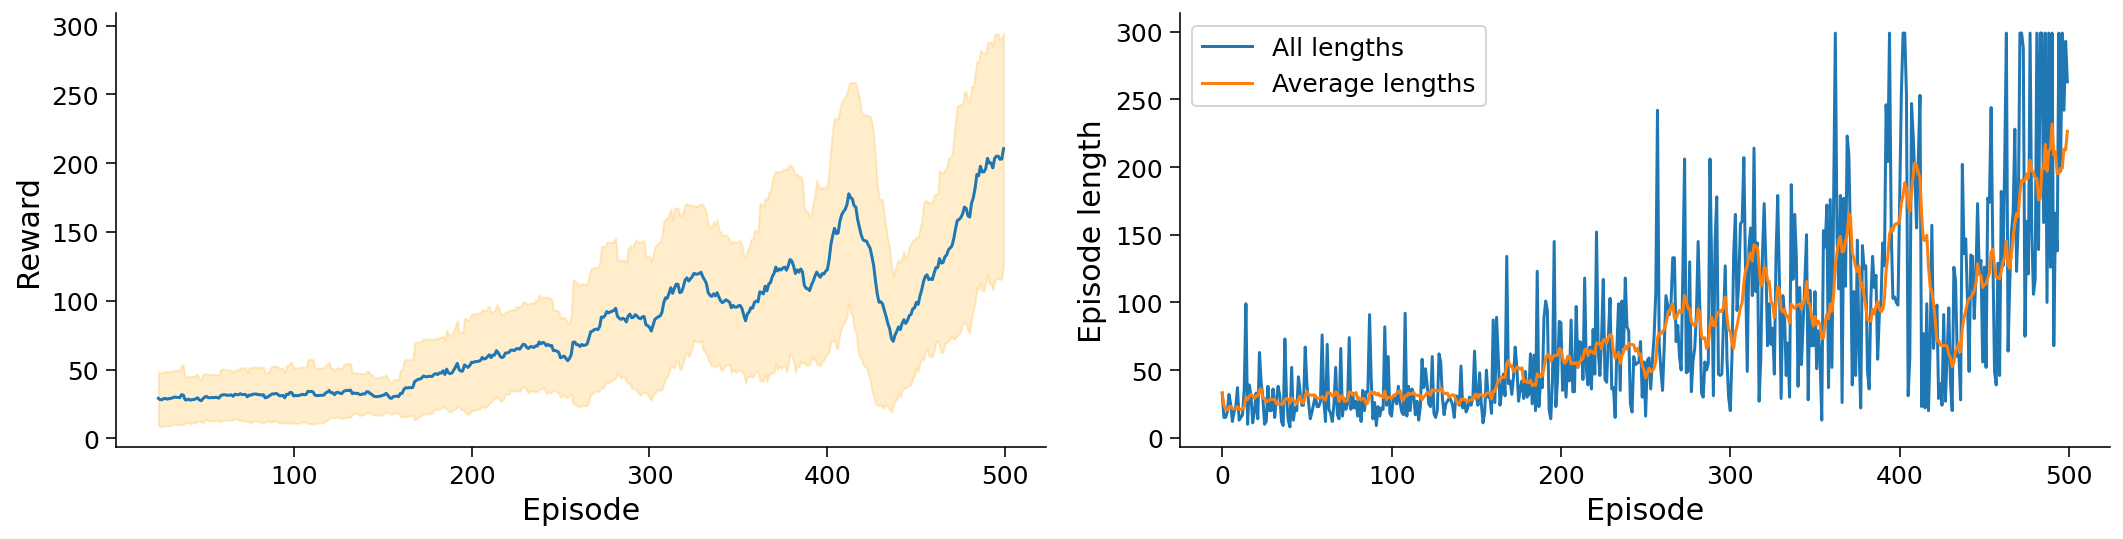

In [71]:
# @title Plot the training performance for Actor Critic


def plot_actor_critic_training(actor_critic, episodes):
  """
  Plot the training performance for Actor Critic

  Args: 
    actor_critic: nn.module
      Actor Critic Network whose performance is to be plotted
    episodes: int
      Number of episodes

  Returns: 
    Nothing
  """
  window = int(episodes / 20)

  plt.figure(figsize=(15, 4))
  plt.subplot(1, 2, 1)

  smoothed_rewards = pd.Series(actor_critic.all_rewards).rolling(window).mean()
  std = pd.Series(actor_critic.all_rewards).rolling(window).std()

  plt.plot(smoothed_rewards, label='Smoothed rewards')
  plt.fill_between(range(len(smoothed_rewards)),
                   smoothed_rewards - std, smoothed_rewards + std,
                   color='orange', alpha=0.2)

  plt.xlabel('Episode')
  plt.ylabel('Reward')

  plt.subplot(1, 2, 2)
  plt.plot(actor_critic.all_lengths, label='All lengths')
  plt.plot(actor_critic.average_lengths, label='Average lengths')
  plt.xlabel('Episode')
  plt.ylabel('Episode length')
  plt.legend()

  plt.tight_layout()
  plt.show()


plot_actor_critic_training(actor_critic, episodes)

### Bonus Exercise 2.2.1: Effect of episodes on performance

Change the episodes from 500 to 3000 and observe the performance impact.

### Bonus Exercise 2.2.2: Effect of learning rate on performance

Modify the hyperparameters related to learning_rate and gamma and observe the impact on the performance.

Be sure to rerun the function definition cells in order to pick up on the updated values.

---
# Appendix and further reading

Books and lecture notes
*   [Reinforcement Learning: an Introduction by Sutton & Barto](http://incompleteideas.net/book/RLbook2018.pdf)
* [Algorithms for Reinforcement Learning by Csaba Szepesvari](https://sites.ualberta.ca/~szepesva/papers/RLAlgsInMDPs.pdf)

Lectures and course 
*   [RL Course by David Silver](https://www.youtube.com/playlist?list=PLzuuYNsE1EZAXYR4FJ75jcJseBmo4KQ9-)
*   [Reinforcement Learning Course | UCL & DeepMind](https://www.youtube.com/playlist?list=PLqYmG7hTraZBKeNJ-JE_eyJHZ7XgBoAyb)
*   [Emma Brunskill Stanford RL Course](https://www.youtube.com/playlist?list=PLoROMvodv4rOSOPzutgyCTapiGlY2Nd8u)
*   [RL Course on Coursera by Martha White & Adam White](https://www.coursera.org/specializations/reinforcement-learning)

More practical:
* [Spinning Up in Deep RL by Josh Achiam](https://spinningup.openai.com/en/latest/)
*   [Acme white paper](https://arxiv.org/abs/2006.00979) & [Colab tutorial](https://github.com/deepmind/acme/blob/master/examples/tutorial.ipynb)

 <br>

[Link to the tweet thread with resources recommended by the community](https://twitter.com/FeryalMP/status/1407272291579355136?s=20). 
 
<br>

This Colab is based on the [EEML 2020 RL practical](https://colab.research.google.com/github/eemlcommunity/PracticalSessions2020/blob/master/rl/EEML2020_RL_Tutorial.ipynb) by Feryal Behbahani & Gheorghe Comanici. If you are interested in JAX you should try the colab. If you are interested in Tensorflow, there is also a version of the colab for the [MLSS 2020 RL Tutorial](https://github.com/Feryal/rl_mlss_2020) that you can try :)
